# Understanding Hired Rides in NYC

## Project Setup

In [1]:
# all import statements needed for the project

import math
from typing import List
import requests
import re
import os
import shutil
import bs4
from bs4 import BeautifulSoup
import pyarrow.parquet as pq
import numpy as np
import pandas as pd
import geopandas as gpd
from sqlalchemy import create_engine, Column, Integer, Float, String, Date, DateTime, MetaData, Table
import sqlite3
import warnings
warnings.filterwarnings("ignore")

In [2]:
# any constants you might need; some have been added for you, and 
# some you need to fill in

TAXI_URL: str = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"

## Location Section
shapefile_path = 'taxi_zones.shp'
zones_gdf = gpd.read_file(shapefile_path)
if zones_gdf.crs is None:
    zones_gdf.set_crs(epsg=2263, inplace=True)  # Example: NY State Plane (EPSG:2263)
zones_gdf = zones_gdf.to_crs(epsg=4326) # Reproject to WGS84 (Latitude/Longitude)
# Calculate centroids for each zone (polygon)
zones_gdf['centroid'] = zones_gdf.geometry.centroid
zones_gdf['latitude'] = zones_gdf['centroid'].y
zones_gdf['longitude'] = zones_gdf['centroid'].x
# Retain only relevant columns: location ID, latitude, and longitude
zones_df = zones_gdf[['LocationID', 'latitude', 'longitude']]
# Restrict the area
LAT_MIN, LAT_MAX = 40.560445, 40.908524
LON_MIN, LON_MAX = -74.242330, -73.717047

DATABASE_URL = "sqlite:///transport_weather.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

## Part 1: Data Preprocessing

### Downloading: programmatically download the Yellow Taxi & High-Volume For-Hire Vehicle (HVFHV) trip data 

In [3]:
def get_taxi_html() -> str:
    response = requests.get(TAXI_URL)
    html = response.content
    return html

def find_taxi_parquet_links() -> List[str]:
    html = get_taxi_html()
    soup = bs4.BeautifulSoup(html, "html.parser")
    HVFHV_a_tags = soup.find_all("a", attrs={"title": "High Volume For-Hire Vehicle Trip Records"})
    yellow_a_tags = soup.find_all("a", attrs={"title": "Yellow Taxi Trip Records"})
    all_a_tags = HVFHV_a_tags + yellow_a_tags
    return [a["href"] for a in all_a_tags]

In [4]:
## Use regex to filter desired datasets
def filter_urls(urls: str, start_year:int, start_month:int, end_year:int, end_month:int) -> List[str]:
    filtered_urls = []
    for url in urls:
        match = re.search(r'(\d{4})-(\d{2})', url)
        if match:
            year, month = int(match.group(1)), int(match.group(2))
            if (start_year < year < end_year) or (year == start_year and month >= start_month) or (year == end_year and month <= end_month):
                filtered_urls.append(url.strip())
    return filtered_urls

# Filtering URLs from January 2020 to August 2024
urls = find_taxi_parquet_links()
filtered_urls = filter_urls(urls, 2020, 1, 2024, 8)

urls = sorted(filtered_urls)

In [5]:
# Directory to save the downloaded files. Create the directory if it doesn't exist
output_directory = "Dataset/"
os.makedirs(output_directory, exist_ok=True)

# Function to download a file
def download_parquet_file(i, url:str, output_directory:str) -> None:
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Raise an error for bad HTTP responses
        
        # Extract file name from the URL
        file_name = url.split("/")[-1]
        file_path = os.path.join(output_directory, file_name)
        
        # Save the file
        with open(file_path, "wb") as file:
            for chunk in response.iter_content(chunk_size=1024):
                file.write(chunk)
        print(f"File {i} Downloaded: {file_name}")
    except requests.RequestException as e:
        print(f"File {i} Failed to download {url}. Error: {e}")

# Download all files
for i, url in enumerate(urls):
    download_parquet_file(i, url, output_directory)

File 0 Downloaded: fhvhv_tripdata_2020-01.parquet
File 1 Downloaded: fhvhv_tripdata_2020-02.parquet
File 2 Downloaded: fhvhv_tripdata_2020-03.parquet
File 3 Downloaded: fhvhv_tripdata_2020-04.parquet
File 4 Downloaded: fhvhv_tripdata_2020-05.parquet
File 5 Downloaded: fhvhv_tripdata_2020-06.parquet
File 6 Downloaded: fhvhv_tripdata_2020-07.parquet
File 7 Downloaded: fhvhv_tripdata_2020-08.parquet
File 8 Downloaded: fhvhv_tripdata_2020-09.parquet
File 9 Downloaded: fhvhv_tripdata_2020-10.parquet
File 10 Downloaded: fhvhv_tripdata_2020-11.parquet
File 11 Downloaded: fhvhv_tripdata_2020-12.parquet
File 12 Downloaded: fhvhv_tripdata_2021-01.parquet
File 13 Downloaded: fhvhv_tripdata_2021-02.parquet
File 14 Downloaded: fhvhv_tripdata_2021-03.parquet
File 15 Downloaded: fhvhv_tripdata_2021-04.parquet
File 16 Downloaded: fhvhv_tripdata_2021-05.parquet
File 17 Downloaded: fhvhv_tripdata_2021-06.parquet
File 18 Downloaded: fhvhv_tripdata_2021-07.parquet
File 19 Downloaded: fhvhv_tripdata_2021-0

In [6]:
output_directory = "Dataset/"
output_directory_yellow = 'Dataset/yellow_tripdata/'
output_directory_uber = 'Dataset/fhvhv_tripdata/'
os.makedirs(output_directory_yellow, exist_ok=True)
os.makedirs(output_directory_uber, exist_ok=True)

for file_name in os.listdir(output_directory):
    file_path = os.path.join(output_directory, file_name)
    
    if os.path.isfile(file_path):
        if file_name.startswith('yellow_tripdata') and file_name.endswith('.parquet'):
            shutil.move(file_path, os.path.join(output_directory_yellow, file_name))
        elif file_name.startswith('fhvhv_tripdata') and file_name.endswith('.parquet'):
            shutil.move(file_path, os.path.join(output_directory_uber, file_name))

### Calculate Sample Size

In [7]:
def calculate_sample_size(population:int, p:float=0.5, e:float=0.05, confidence:float=0.95) -> int:
    # Z-score for the given confidence level
    Z = {
        0.90: 1.645,
        0.95: 1.96,
        0.99: 2.576
    }.get(confidence, 1.96)  # Default to 95% confidence if not specified
    
    # Step 1: Cochran's formula for infinite population
    n0 = (Z**2 * p * (1 - p)) / (e**2)
    
    # Step 2: Adjust for finite population
    n = n0 / (1 + (n0 - 1) / population)
    
    return math.ceil(n)

def calculate_stable_sample_size(monthly_populations: List[int], p=0.5, e=0.05, confidence=0.99, method='max') -> int:
    
    sample_sizes = [calculate_sample_size(N, p, e, confidence) for N in monthly_populations]
    
    if method == 'max':
        return max(sample_sizes)
    elif method == 'average':
        return math.ceil(sum(sample_sizes) / len(sample_sizes))
    elif method == 'safety':
        return math.ceil(max(sample_sizes) * 1.1)  # Add a 10% safety margin
    else:
        raise ValueError("Invalid method. Choose from 'max', 'average', or 'safety'.")

In [8]:
## Yellow Taxi
yellow_file_folder = output_directory_yellow
yellow_file_names = [f for f in os.listdir(yellow_file_folder) if os.path.isfile(os.path.join(yellow_file_folder, f))]

monthly_populations_yellow = []
for file in yellow_file_names:
    parquet_file = pq.ParquetFile(yellow_file_folder + file)
    monthly_populations_yellow.append(parquet_file.metadata.num_rows)
    
# Example monthly population sizes
stable_size_yellow = calculate_stable_sample_size(monthly_populations_yellow, method='average')
print(f"Yellow Taxi Stable sample size: {stable_size_yellow}")


Yellow Taxi Stable sample size: 664


In [9]:
## Uber
fhvhv_file_folder = output_directory_uber
fhvhv_file_names = [f for f in os.listdir(fhvhv_file_folder) if os.path.isfile(os.path.join(fhvhv_file_folder, f))]

monthly_populations_uber = []
for file in fhvhv_file_names:
    parquet_file = pq.ParquetFile(fhvhv_file_folder + file)
    monthly_populations_uber.append(parquet_file.metadata.num_rows)
    
# Example monthly population sizes
stable_size_uber = calculate_stable_sample_size(monthly_populations_uber, method='average')
print(f"Uber Stable sample size: {stable_size_uber}")

Uber Stable sample size: 664


### Process Taxi Data

In [10]:
output_directory_yellow = "Clean_Sampled_Dataset/Yellow/"
os.makedirs(output_directory_yellow, exist_ok=True)

In [11]:
def get_and_clean_taxi_month(file:str) -> None:
    trips_df = pd.read_parquet(yellow_file_folder + file)
    print('Current Processing:', file)

    # Merge trip data with zone centroids for pickups and dropoffs
    trips_with_pickup = trips_df.merge(
        zones_df,
        how='left',
        left_on='PULocationID',
        right_on='LocationID'
    ).rename(columns={'latitude': 'pickup_latitude', 'longitude': 'pickup_longitude'})

    trips_with_locations = trips_with_pickup.merge(
        zones_df,
        how='left',
        left_on='DOLocationID',
        right_on='LocationID',
        suffixes=('', '_dropoff')
    ).rename(columns={'latitude': 'dropoff_latitude', 'longitude': 'dropoff_longitude'})

    # Filter out trips with invalid location IDs
    valid_trips = trips_with_locations.dropna(subset=['pickup_latitude', 'dropoff_latitude'])
    valid_trips = valid_trips[
        (valid_trips['pickup_latitude'].between(LAT_MIN, LAT_MAX)) &
        (valid_trips['pickup_longitude'].between(LON_MIN, LON_MAX)) &
        (valid_trips['dropoff_latitude'].between(LAT_MIN, LAT_MAX)) &
        (valid_trips['dropoff_longitude'].between(LON_MIN, LON_MAX))
    ]
    ## Delete original locationID columns
    valid_trips.drop(['PULocationID','DOLocationID','LocationID','LocationID_dropoff'],axis=1,inplace=True)
    
    valid_trips.columns = valid_trips.columns.str.lower()
    
    ## Delete records that trip_distance is missing or trip_distance <= 0, and convert datatype into Float
    valid_trips = valid_trips.dropna(subset=['trip_distance'])
    valid_trips = valid_trips[valid_trips['trip_distance']>0]
    valid_trips['trip_distance'] = valid_trips['trip_distance'].astype(float)
    
    ## Delete records that passenger_count is missing or passenger_count <= 0, and convert datatype into Integer
    valid_trips = valid_trips.dropna(subset=['passenger_count'])
    valid_trips = valid_trips[valid_trips['passenger_count']>0]
    valid_trips['passenger_count'] = valid_trips['passenger_count'].astype(int)
    
    ## Delete records that where Fare_amount, Total_amount, or Tolls_amount are negative.
    valid_trips = valid_trips[
        (valid_trips['fare_amount']>=0) &
        (valid_trips['total_amount']>=0) &
        (valid_trips['tolls_amount']>=0)
        ]
    
    ## Delete records that Payment_type not in the valid range (1-6), and convert datatype into Integer
    valid_trips['payment_type'] = valid_trips['payment_type'].astype(int)
    valid_trips = valid_trips[valid_trips['payment_type'].between(1,6)]
    
    ## Delete records that RateCodeID not in the valid range (1-6), and convert datatype into Integer
    valid_trips['ratecodeid'] = valid_trips['ratecodeid'].astype(int)
    valid_trips = valid_trips[valid_trips['ratecodeid'].between(1,6)]
    valid_trips = valid_trips.rename(columns={'ratecodeid':'RateCodeID',})
    
    ## Convert store_and_fwd_flag into 0 and 1
    valid_trips['store_and_fwd_flag'] = valid_trips['store_and_fwd_flag'].map({'Y':1,'N':0}).fillna(0)
    
    ## Convert airport_fee into Float
    valid_trips['airport_fee'] = pd.to_numeric(valid_trips['airport_fee'], errors='coerce').fillna(0)
    
    ## Rename: extra -> Miscellaneous_Extras, tpep_pickup_datetime → pickup_datetime, tpep_dropoff_datetime → dropoff_datetime
    valid_trips = valid_trips.rename(
        columns={'extra':'Miscellaneous_Extras','tpep_pickup_datetime':'pickup_datetime','tpep_dropoff_datetime':'dropoff_datetime'})
    
    ## Delete records that dropoff_datetime is earlier than pickup_datetime.
    valid_trips = valid_trips[valid_trips['dropoff_datetime'] >= valid_trips['pickup_datetime']]
    
    ## Sampling & Save to parquet file
    valid_trips = valid_trips.sample(n=stable_size_yellow, random_state=42).reset_index(drop=True)
    valid_trips.to_parquet(output_directory_yellow + file)

In [12]:
for i, file in enumerate(yellow_file_names[:]):
    get_and_clean_taxi_month(file)

Current Processing: yellow_tripdata_2020-01.parquet
Current Processing: yellow_tripdata_2020-02.parquet
Current Processing: yellow_tripdata_2020-03.parquet
Current Processing: yellow_tripdata_2020-04.parquet
Current Processing: yellow_tripdata_2020-05.parquet
Current Processing: yellow_tripdata_2020-06.parquet
Current Processing: yellow_tripdata_2020-07.parquet
Current Processing: yellow_tripdata_2020-08.parquet
Current Processing: yellow_tripdata_2020-09.parquet
Current Processing: yellow_tripdata_2020-10.parquet
Current Processing: yellow_tripdata_2020-11.parquet
Current Processing: yellow_tripdata_2020-12.parquet
Current Processing: yellow_tripdata_2021-01.parquet
Current Processing: yellow_tripdata_2021-02.parquet
Current Processing: yellow_tripdata_2021-03.parquet
Current Processing: yellow_tripdata_2021-04.parquet
Current Processing: yellow_tripdata_2021-05.parquet
Current Processing: yellow_tripdata_2021-06.parquet
Current Processing: yellow_tripdata_2021-07.parquet
Current Proc

In [13]:
yellow_sampled_records = pd.DataFrame()
yellow_sampled_file_names = [f for f in os.listdir(output_directory_yellow) if os.path.isfile(os.path.join(output_directory_yellow, f))]

for file in yellow_sampled_file_names:
    sampled_df = pd.read_parquet(output_directory_yellow + file)
    yellow_sampled_records = pd.concat([yellow_sampled_records,sampled_df],axis=0)
    
output_directory_final = "Clean_Sampled_Dataset/Final/"
os.makedirs(output_directory_final, exist_ok=True)
yellow_sampled_records.to_parquet(output_directory_final + 'Yellow_all.parquet')

In [14]:
taxi_data = yellow_sampled_records
taxi_data.head()

,vendorid,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,RateCodeID,store_and_fwd_flag,payment_type,fare_amount,Miscellaneous_Extras,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
0,1,2020-01-25 15:18:34,2020-01-25 15:24:03,1,0.60,1,0,1,5.0,2.5,...,1.00,0.0,0.3,9.30,2.5,0.0,40.740337,-73.990458,40.732579,-73.994305
1,1,2020-01-31 22:47:15,2020-01-31 23:09:04,1,4.00,1,0,1,18.5,3.0,...,4.45,0.0,0.3,26.75,2.5,0.0,40.727620,-73.985937,40.729506,-73.949540
2,1,2020-01-12 10:43:53,2020-01-12 10:51:52,1,1.40,1,0,1,7.5,2.5,...,2.15,0.0,0.3,12.95,2.5,0.0,40.717773,-74.007880,40.734576,-74.002875
3,2,2020-01-23 17:35:31,2020-01-23 17:41:18,1,1.05,1,0,1,6.0,1.0,...,2.06,0.0,0.3,12.36,2.5,0.0,40.765484,-73.954739,40.780436,-73.957012
4,1,2020-01-09 17:16:48,2020-01-09 17:45:01,2,2.70,1,0,1,18.0,3.5,...,5.55,0.0,0.3,27.85,2.5,0.0,40.780436,-73.957012,40.748497,-73.992438


In [15]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37184 entries, 0 to 663
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   vendorid               37184 non-null  int64         
 1   pickup_datetime        37184 non-null  datetime64[us]
 2   dropoff_datetime       37184 non-null  datetime64[us]
 3   passenger_count        37184 non-null  int64         
 4   trip_distance          37184 non-null  float64       
 5   RateCodeID             37184 non-null  int64         
 6   store_and_fwd_flag     37184 non-null  int64         
 7   payment_type           37184 non-null  int64         
 8   fare_amount            37184 non-null  float64       
 9   Miscellaneous_Extras   37184 non-null  float64       
 10  mta_tax                37184 non-null  float64       
 11  tip_amount             37184 non-null  float64       
 12  tolls_amount           37184 non-null  float64       
 13  improvem

In [16]:
taxi_data.describe()

,vendorid,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,RateCodeID,store_and_fwd_flag,payment_type,fare_amount,Miscellaneous_Extras,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
count,37184.000000,37184,37184,37184.000000,37184.00000,37184.000000,37184.000000,37184.000000,37184.000000,37184.000000,...,37184.000000,37184.000000,37184.000000,37184.000000,37184.000000,37184.000000,37184.000000,37184.000000,37184.000000,37184.000000
mean,1.727221,2022-05-02 00:15:05.196455,2022-05-02 00:31:09.242389,1.429674,3.14086,1.039937,0.009171,1.229857,14.919423,1.231025,...,2.765244,0.409460,0.553679,22.136030,2.326404,0.082347,40.753944,-73.967747,40.755782,-73.971609
min,1.000000,2020-01-01 00:46:20,2020-01-01 00:49:27,1.000000,0.01000,1.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.592023,-74.071771,40.576961,-74.174000
25%,1.000000,2021-03-01 06:07:27.500000,2021-03-01 06:14:43.500000,1.000000,1.06000,1.000000,0.000000,1.000000,7.200000,0.000000,...,0.020000,0.000000,0.300000,12.360000,2.500000,0.000000,40.740439,-73.989845,40.740337,-73.989845
50%,2.000000,2022-05-01 00:20:16,2022-05-01 00:48:41.500000,1.000000,1.78000,1.000000,0.000000,1.000000,10.500000,0.500000,...,2.190000,0.000000,0.300000,16.560000,2.500000,0.000000,40.758028,-73.977698,40.758028,-73.977698
75%,2.000000,2023-06-30 22:56:06.500000,2023-06-30 23:00:25.750000,1.000000,3.16000,1.000000,0.000000,1.000000,16.500000,2.500000,...,3.500000,0.000000,1.000000,23.800000,2.500000,0.000000,40.773633,-73.965146,40.775932,-73.959635
max,2.000000,2024-08-31 23:04:44,2024-08-31 23:26:45,7.000000,47.96000,5.000000,1.000000,4.000000,159.000000,11.750000,...,208.000000,36.000000,1.000000,224.100000,2.500000,1.750000,40.877138,-73.735554,40.899529,-73.726655
std,0.445394,NaN,NaN,0.971560,3.97191,0.254993,0.095324,0.452647,13.447006,1.496043,...,3.442572,1.735434,0.336562,17.365268,0.635504,0.345755,0.030316,0.044121,0.031729,0.035067


### Process Uber Data

In [17]:
output_directory_uber = "Clean_Sampled_Dataset/Uber/"
os.makedirs(output_directory_uber, exist_ok=True)
output_directory_final = "Clean_Sampled_Dataset/Final/"
os.makedirs(output_directory_final, exist_ok=True)

In [18]:
def get_and_clean_uber_month(file:str) -> None:
    trips_df = pd.read_parquet(fhvhv_file_folder + file)
    print('Current Processing:', file)
    
    ## Retain records that are Uber rides
    trips_df = trips_df[trips_df['hvfhs_license_num'] == 'HV0003']

    # Merge trip data with zone centroids for pickups and dropoffs
    trips_with_pickup = trips_df.merge(
        zones_df,
        how='left',
        left_on='PULocationID',
        right_on='LocationID'
    ).rename(columns={'latitude': 'pickup_latitude', 'longitude': 'pickup_longitude'})

    trips_with_locations = trips_with_pickup.merge(
        zones_df,
        how='left',
        left_on='DOLocationID',
        right_on='LocationID',
        suffixes=('', '_dropoff')
    ).rename(columns={'latitude': 'dropoff_latitude', 'longitude': 'dropoff_longitude'})

    # Filter out trips with invalid location IDs
    valid_trips = trips_with_locations.dropna(subset=['pickup_latitude', 'dropoff_latitude'])

    # Delete records that start_pos or end_pos is out of range
    LAT_MIN, LAT_MAX = 40.560445, 40.908524
    LON_MIN, LON_MAX = -74.242330, -73.717047
    
    valid_trips = valid_trips[
        (valid_trips['pickup_latitude'].between(LAT_MIN, LAT_MAX)) &
        (valid_trips['pickup_longitude'].between(LON_MIN, LON_MAX)) &
        (valid_trips['dropoff_latitude'].between(LAT_MIN, LAT_MAX)) &
        (valid_trips['dropoff_longitude'].between(LON_MIN, LON_MAX))
    ]
    ## Delete original locationID columns
    valid_trips.drop(['PULocationID','DOLocationID','LocationID','LocationID_dropoff'],axis=1,inplace=True)
    
    valid_trips.columns = valid_trips.columns.str.lower()
    
    ## Delete records that trip_distance is missing or trip_distance <= 0, and convert datatype into Float
    valid_trips = valid_trips.dropna(subset=['trip_miles'])
    valid_trips = valid_trips[valid_trips['trip_miles']>0]
    valid_trips['trip_miles'] = valid_trips['trip_miles'].astype(float)
    
    ## Delete records that trip_time is missing or trip_distance <= 0, and convert datatype into Float
    valid_trips = valid_trips.dropna(subset=['trip_time'])
    valid_trips = valid_trips[valid_trips['trip_time']>0]
    valid_trips['trip_time'] = valid_trips['trip_time'].astype(float)
    
    ## Delete records that where base_passenger_fare, tolls, sales_tax, bcf, tips, congestion_surcharge or driver_pay are negative.
    valid_trips = valid_trips[
        (valid_trips['base_passenger_fare']>=0) &
        (valid_trips['tolls']>=0) &
        (valid_trips['sales_tax']>=0) &
        (valid_trips['bcf']>=0) &
        (valid_trips['tips']>=0) &
        (valid_trips['congestion_surcharge']>=0) &
        (valid_trips['driver_pay']>=0) 
        ]
    
    ## Convert shared_request_flag, shared_match_flag, access_a_ride_flag, wav_request_flag, wav_match_flag into 0 and 1
    valid_trips['shared_request_flag'] = valid_trips['shared_request_flag'].map({'Y':1,'N':0}).fillna(0)
    valid_trips['shared_match_flag'] = valid_trips['shared_match_flag'].map({'Y':1,'N':0}).fillna(0)
    valid_trips['access_a_ride_flag'] = valid_trips['access_a_ride_flag'].map({'Y':1,'N':0}).fillna(0)
    valid_trips['wav_request_flag'] = valid_trips['wav_request_flag'].map({'Y':1,'N':0}).fillna(0)
    valid_trips['wav_match_flag'] = valid_trips['wav_match_flag'].map({'Y':1,'N':0}).fillna(0)
    
    ## Delete records that dropoff_datetime is earlier than pickup_datetime.
    valid_trips = valid_trips[valid_trips['dropoff_datetime'] >= valid_trips['pickup_datetime']]
    
    ## Delete records that on_scene_datetime is earlier than request_datetime.
    valid_trips = valid_trips[valid_trips['on_scene_datetime'] >= valid_trips['request_datetime']]
    
    ## Rename: bcf -> Black_Car_Fund
    valid_trips = valid_trips.rename(
        columns={'bcf':'Black_Car_Fund',})
    
    ## Delete useless columns: dispatching_base_num, Hvfhs_license_num, originating_base_num
    valid_trips = valid_trips.drop(['hvfhs_license_num','dispatching_base_num','originating_base_num'], axis=1)
    
    ## Sampling & Save to parquet file
    valid_trips = valid_trips.sample(n=stable_size_uber, random_state=42).reset_index(drop=True)
    valid_trips.to_parquet(output_directory_uber + file)


In [19]:
for i, file in enumerate(fhvhv_file_names[:]):
    get_and_clean_uber_month(file)

Current Processing: fhvhv_tripdata_2020-01.parquet
Current Processing: fhvhv_tripdata_2020-02.parquet
Current Processing: fhvhv_tripdata_2020-03.parquet
Current Processing: fhvhv_tripdata_2020-04.parquet
Current Processing: fhvhv_tripdata_2020-05.parquet
Current Processing: fhvhv_tripdata_2020-06.parquet
Current Processing: fhvhv_tripdata_2020-07.parquet
Current Processing: fhvhv_tripdata_2020-08.parquet
Current Processing: fhvhv_tripdata_2020-09.parquet
Current Processing: fhvhv_tripdata_2020-10.parquet
Current Processing: fhvhv_tripdata_2020-11.parquet
Current Processing: fhvhv_tripdata_2020-12.parquet
Current Processing: fhvhv_tripdata_2021-01.parquet
Current Processing: fhvhv_tripdata_2021-02.parquet
Current Processing: fhvhv_tripdata_2021-03.parquet
Current Processing: fhvhv_tripdata_2021-04.parquet
Current Processing: fhvhv_tripdata_2021-05.parquet
Current Processing: fhvhv_tripdata_2021-06.parquet
Current Processing: fhvhv_tripdata_2021-07.parquet
Current Processing: fhvhv_tripd

In [20]:
uber_sampled_records = pd.DataFrame()
uber_sampled_file_names = [f for f in os.listdir(output_directory_uber) if os.path.isfile(os.path.join(output_directory_uber, f))]

for file in uber_sampled_file_names:
    sampled_df = pd.read_parquet(output_directory_uber + file)
    uber_sampled_records = pd.concat([uber_sampled_records,sampled_df],axis=0)
    
uber_sampled_records.to_parquet(output_directory_final + 'Uber_all.parquet')

In [21]:
uber_data = uber_sampled_records
uber_data.head()

,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,trip_miles,trip_time,base_passenger_fare,tolls,Black_Car_Fund,sales_tax,...,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
0,2020-01-11 18:47:52,2020-01-11 18:49:25,2020-01-11 18:50:40,2020-01-11 18:58:32,1.26,472.0,8.63,0.0,0.22,0.77,...,5.39,0,0,0.0,0,0,40.601429,-73.983537,40.601429,-73.983537
1,2020-01-31 15:01:20,2020-01-31 15:01:29,2020-01-31 15:02:42,2020-01-31 15:13:28,2.14,646.0,4.73,0.0,0.12,0.42,...,7.67,0,0,0.0,0,0,40.760314,-73.941997,40.771570,-73.928333
2,2020-01-06 11:32:29,2020-01-06 11:35:08,2020-01-06 11:35:58,2020-01-06 11:56:02,3.61,1204.0,8.98,0.0,0.22,0.80,...,13.88,1,0,0.0,0,0,40.757312,-73.885317,40.737699,-73.924673
3,2020-01-19 20:39:28,2020-01-19 20:40:20,2020-01-19 20:42:46,2020-01-19 20:53:33,2.33,647.0,8.83,0.0,0.22,0.78,...,7.89,0,0,0.0,0,0,40.706527,-73.901709,40.694994,-73.922240
4,2020-01-22 05:01:59,2020-01-22 05:03:35,2020-01-22 05:05:49,2020-01-22 05:14:41,2.06,532.0,9.65,0.0,0.24,0.86,...,6.64,0,0,0.0,0,0,40.626273,-73.930097,40.620924,-73.956825


In [22]:
uber_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37184 entries, 0 to 663
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   request_datetime      37184 non-null  datetime64[us]
 1   on_scene_datetime     37184 non-null  datetime64[us]
 2   pickup_datetime       37184 non-null  datetime64[us]
 3   dropoff_datetime      37184 non-null  datetime64[us]
 4   trip_miles            37184 non-null  float64       
 5   trip_time             37184 non-null  float64       
 6   base_passenger_fare   37184 non-null  float64       
 7   tolls                 37184 non-null  float64       
 8   Black_Car_Fund        37184 non-null  float64       
 9   sales_tax             37184 non-null  float64       
 10  congestion_surcharge  37184 non-null  float64       
 11  airport_fee           27280 non-null  float64       
 12  tips                  37184 non-null  float64       
 13  driver_pay            3

In [23]:
uber_data.describe()

,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,trip_miles,trip_time,base_passenger_fare,tolls,Black_Car_Fund,sales_tax,...,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
count,37184,37184,37184,37184,37184.000000,37184.000000,37184.000000,37184.000000,37184.000000,37184.000000,...,37184.000000,37184.000000,37184.000000,37184.000000,37184.000000,37184.000000,37184.000000,37184.000000,37184.000000,37184.000000
mean,2022-05-01 23:55:11.932820,2022-05-01 23:58:53.492389,2022-05-01 23:59:59.119352,2022-05-02 00:17:43.175855,4.360401,1063.879787,20.921077,0.634296,0.612010,1.877993,...,16.814301,0.021810,0.008229,0.000215,0.001694,0.064732,40.737384,-73.934362,40.737447,-73.934261
min,2020-01-01 00:23:24,2020-01-01 00:25:57,2020-01-01 00:29:47,2020-01-01 00:38:28,0.020000,23.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.561994,-74.186419,40.561994,-74.186419
25%,2021-02-28 23:45:55.500000,2021-02-28 23:47:05,2021-02-28 23:47:20.750000,2021-02-28 23:53:25.750000,1.540000,557.000000,10.550000,0.000000,0.290000,0.920000,...,8.270000,0.000000,0.000000,0.000000,0.000000,0.000000,40.691507,-73.984196,40.690787,-73.984052
50%,2022-04-30 23:47:52.500000,2022-04-30 23:51:57.500000,2022-04-30 23:53:14,2022-05-01 00:03:40,2.790000,878.000000,16.520000,0.000000,0.470000,1.450000,...,13.280000,0.000000,0.000000,0.000000,0.000000,0.000000,40.737699,-73.948789,40.739496,-73.947442
75%,2023-07-01 00:11:25.500000,2023-07-01 00:14:47.500000,2023-07-01 00:14:59.750000,2023-07-01 00:35:35.750000,5.560000,1371.000000,26.330000,0.000000,0.770000,2.370000,...,21.560000,0.000000,0.000000,0.000000,0.000000,0.000000,40.774376,-73.899536,40.774376,-73.895620
max,2024-08-31 20:56:10,2024-08-31 21:00:51,2024-08-31 21:02:52,2024-08-31 21:27:55,78.870000,8822.000000,259.090000,45.140000,8.200000,24.260000,...,176.150000,1.000000,1.000000,1.000000,1.000000,1.000000,40.899529,-73.726655,40.899529,-73.726655
std,NaN,NaN,NaN,NaN,4.270252,723.080127,15.120357,2.428773,0.485812,1.418026,...,12.084181,0.146066,0.090343,0.014666,0.041127,0.246056,0.068482,0.065073,0.068916,0.067372


### Processing Weather Data: Hourly

In [24]:
weather_data_file_folder = 'Dataset/weather_data/'
weather_data_files = ['2020_weather.csv','2021_weather.csv','2022_weather.csv','2023_weather.csv','2024_weather.csv']
output_directory_final = "Clean_Sampled_Dataset/Final/"
os.makedirs(output_directory_final, exist_ok=True)

In [25]:
weather_data_hourly_df = pd.DataFrame()
for file in weather_data_files:
    print("Current Processing:", file)
    weather_data = pd.read_csv(weather_data_file_folder + file)

    ## Split Date and Hour
    weather_data[['Date', 'Hour']] = weather_data['DATE'].str.split('T', expand=True)
    
    weather_data_hourly = weather_data[weather_data['Hour'] !='23:59:00']
    weather_data_hourly['Hour'] = weather_data_hourly['Hour'].str.split(':').str[0]
    weather_data_hourly = weather_data_hourly.groupby(['Date','Hour']).first().reset_index()

    original_columns = list(weather_data_hourly.columns)
    columns_to_drop = ['DATE','ELEVATION','STATION','NAME','LATITUDE','LONGITUDE','NormalsCoolingDegreeDay','NormalsHeatingDegreeDay','Sunrise', 'Sunset','WindEquipmentChangeDate'] \
    + ['AWND','CDSD','CLDD','DSNW','HDSD','HTDD','DYTS','DYHF',] \
    + ['HourlyPresentWeatherType','HourlySkyConditions','REM','HourlyWindDirection'] \
    + [col for col in original_columns if col.startswith('Daily')] \
    + [col for col in original_columns if col.startswith('Monthly')] \
    + [col for col in original_columns if col.startswith('Backup')] \
    + [col for col in original_columns if col.startswith('ShortDuration')]
    weather_data_hourly = weather_data_hourly.drop(columns_to_drop,axis=1)

    ## Transform data type & Fill missing values
    weather_data_hourly['Hour'] = weather_data_hourly['Hour'].astype(int)
    weather_data_hourly['HourlyAltimeterSetting'] = pd.to_numeric(weather_data_hourly['HourlyAltimeterSetting'], errors='coerce')
    weather_data_hourly['HourlyAltimeterSetting'] = weather_data_hourly['HourlyAltimeterSetting'].fillna(weather_data_hourly['HourlyAltimeterSetting'].mean())
    weather_data_hourly['HourlyDewPointTemperature'] = pd.to_numeric(weather_data_hourly['HourlyDewPointTemperature'], errors='coerce')
    weather_data_hourly['HourlyDewPointTemperature'] = weather_data_hourly['HourlyDewPointTemperature'].fillna(weather_data_hourly['HourlyDewPointTemperature'].mean())
    weather_data_hourly['HourlyDryBulbTemperature'] = pd.to_numeric(weather_data_hourly['HourlyDryBulbTemperature'], errors='coerce')
    weather_data_hourly['HourlyDryBulbTemperature'] = weather_data_hourly['HourlyDryBulbTemperature'].fillna(weather_data_hourly['HourlyDryBulbTemperature'].mean())
    weather_data_hourly['HourlySeaLevelPressure'] = pd.to_numeric(weather_data_hourly['HourlySeaLevelPressure'], errors='coerce')
    weather_data_hourly['HourlySeaLevelPressure'] = weather_data_hourly['HourlySeaLevelPressure'].fillna(weather_data_hourly['HourlySeaLevelPressure'].mean())
    weather_data_hourly['HourlyStationPressure'] = pd.to_numeric(weather_data_hourly['HourlyStationPressure'], errors='coerce')
    weather_data_hourly['HourlyStationPressure'] = weather_data_hourly['HourlyStationPressure'].fillna(weather_data_hourly['HourlyStationPressure'].mean())

    weather_data_hourly['HourlyVisibility'] = weather_data_hourly['HourlyVisibility'].str.extract(r'(\d+\.\d+)', expand=False)
    weather_data_hourly['HourlyVisibility'] = pd.to_numeric(weather_data_hourly['HourlyVisibility'], errors='coerce')
    weather_data_hourly['HourlyVisibility'] = weather_data_hourly['HourlyVisibility'].fillna(weather_data_hourly['HourlyVisibility'].mean())

    weather_data_hourly['HourlyPrecipitation'] = weather_data_hourly['HourlyPrecipitation'].replace('T', 0.0005)
    weather_data_hourly['HourlyPrecipitation'] = weather_data_hourly['HourlyPrecipitation'].replace(['M', ''], np.nan)
    weather_data_hourly['HourlyPrecipitation'] = weather_data_hourly['HourlyPrecipitation'].fillna(0)
    weather_data_hourly['HourlyPrecipitation'] = pd.to_numeric(weather_data_hourly['HourlyPrecipitation'], errors='coerce')
    weather_data_hourly['HourlyPrecipitation'] = weather_data_hourly['HourlyPrecipitation'].fillna(0)

    weather_data_hourly['HourlyPressureChange'] = pd.to_numeric(weather_data_hourly['HourlyPressureChange'], errors='coerce')
    weather_data_hourly['HourlyPressureChange'] = weather_data_hourly['HourlyPressureChange'].fillna(0)
    weather_data_hourly['HourlyPressureTendency'] = pd.to_numeric(weather_data_hourly['HourlyPressureTendency'], errors='coerce')
    weather_data_hourly['HourlyPressureTendency'] = weather_data_hourly['HourlyPressureTendency'].fillna(0)
    weather_data_hourly['HourlyRelativeHumidity'] = pd.to_numeric(weather_data_hourly['HourlyPrecipitation'], errors='coerce')
    weather_data_hourly['HourlyRelativeHumidity'] = weather_data_hourly['HourlyRelativeHumidity'].fillna(0)
    weather_data_hourly['HourlyWetBulbTemperature'] = pd.to_numeric(weather_data_hourly['HourlyWetBulbTemperature'], errors='coerce')
    weather_data_hourly['HourlyWetBulbTemperature'] = weather_data_hourly['HourlyWetBulbTemperature'].fillna(weather_data_hourly['HourlyWetBulbTemperature'].mean())
    weather_data_hourly['HourlyWindGustSpeed'] = weather_data_hourly['HourlyWindGustSpeed'].fillna(weather_data_hourly['HourlyWindGustSpeed'].mean())
    weather_data_hourly['HourlyWindSpeed'] = weather_data_hourly['HourlyWindSpeed'].fillna(weather_data_hourly['HourlyWindSpeed'].mean())

    weather_data_hourly_df = pd.concat([weather_data_hourly_df,weather_data_hourly],axis=0)
    
weather_data_hourly_df['Date'] = pd.to_datetime(weather_data_hourly_df['Date'])
weather_data_hourly_df.to_parquet(output_directory_final + 'Weather_hourly.parquet')

Current Processing: 2020_weather.csv
Current Processing: 2021_weather.csv
Current Processing: 2022_weather.csv
Current Processing: 2023_weather.csv
Current Processing: 2024_weather.csv


In [26]:
hourly_weather_data = weather_data_hourly_df
hourly_weather_data.head()

,Date,Hour,REPORT_TYPE,SOURCE,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyPressureChange,HourlyPressureTendency,HourlyRelativeHumidity,HourlySeaLevelPressure,HourlyStationPressure,HourlyVisibility,HourlyWetBulbTemperature,HourlyWindGustSpeed,HourlyWindSpeed
0,2020-01-01,0,FM-15,7,29.66,26.0,40.0,0.0,-0.01,3.0,0.0,29.64,29.49,10.0,35.0,21.300203,8.0
1,2020-01-01,1,FM-15,7,29.67,27.0,39.0,0.0,0.00,0.0,0.0,29.65,29.50,10.0,34.0,17.000000,8.0
2,2020-01-01,2,FM-15,7,29.68,26.0,39.0,0.0,0.00,0.0,0.0,29.66,29.51,10.0,34.0,23.000000,14.0
3,2020-01-01,3,FM-15,7,29.70,24.0,39.0,0.0,-0.03,3.0,0.0,29.67,29.53,10.0,33.0,23.000000,11.0
4,2020-01-01,4,FM-15,7,29.70,23.0,38.0,0.0,0.00,0.0,0.0,29.67,29.53,10.0,32.0,20.000000,6.0


In [27]:
hourly_weather_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42143 entries, 0 to 7086
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       42143 non-null  datetime64[ns]
 1   Hour                       42143 non-null  int64         
 2   REPORT_TYPE                42143 non-null  object        
 3   SOURCE                     42143 non-null  int64         
 4   HourlyAltimeterSetting     42143 non-null  float64       
 5   HourlyDewPointTemperature  42143 non-null  float64       
 6   HourlyDryBulbTemperature   42143 non-null  float64       
 7   HourlyPrecipitation        42143 non-null  float64       
 8   HourlyPressureChange       42143 non-null  float64       
 9   HourlyPressureTendency     42143 non-null  float64       
 10  HourlyRelativeHumidity     42143 non-null  float64       
 11  HourlySeaLevelPressure     42143 non-null  float64       
 12  HourlyStat

In [28]:
hourly_weather_data.describe()

,Date,Hour,SOURCE,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyPressureChange,HourlyPressureTendency,HourlyRelativeHumidity,HourlySeaLevelPressure,HourlyStationPressure,HourlyVisibility,HourlyWetBulbTemperature,HourlyWindGustSpeed,HourlyWindSpeed
count,42143,42143.000000,42143.000000,42143.000000,42143.000000,42143.000000,42143.000000,42143.000000,42143.000000,42143.000000,42143.000000,42143.000000,42143.000000,42143.000000,42143.000000,42143.000000
mean,2022-05-27 14:51:45.142016512,11.497425,6.957407,30.042690,42.868218,57.421804,0.002872,-0.000168,1.423202,0.002872,30.015235,29.872520,9.082238,50.506325,21.291719,5.100049
min,2020-01-01 00:00:00,0.000000,4.000000,28.860000,-15.000000,4.000000,0.000000,-0.310000,0.000000,0.000000,28.840000,28.690000,0.000000,2.000000,16.000000,0.000000
25%,2021-03-14 12:00:00,5.000000,7.000000,29.900000,28.000000,44.000000,0.000000,0.000000,0.000000,0.000000,29.870000,29.730000,10.000000,38.000000,20.551695,3.000000
50%,2022-05-28 00:00:00,11.000000,7.000000,30.040000,44.000000,58.000000,0.000000,0.000000,0.000000,0.000000,30.010000,29.870000,10.000000,51.000000,21.300203,5.000000
75%,2023-08-10 00:00:00,17.000000,7.000000,30.190000,59.000000,71.000000,0.000000,0.000000,1.000000,0.000000,30.160000,30.020000,10.000000,64.000000,21.475073,7.000000
max,2024-10-22 00:00:00,23.000000,7.000000,30.760000,80.000000,97.000000,1.600000,0.320000,9.000000,1.600000,30.740000,30.590000,10.000000,81.000000,51.000000,2237.000000
std,NaN,6.922439,0.249271,0.225974,18.606820,16.499179,0.022523,0.026283,2.582359,0.022523,0.226635,0.225671,2.190958,15.150230,1.866752,15.778008


### Processing Weather Data: Daily

In [29]:
output_directory_final = "Clean_Sampled_Dataset/Final/"
os.makedirs(output_directory_final, exist_ok=True)

In [30]:
weather_data_daily_df = pd.DataFrame()
for file in weather_data_files:
    print("Current Processing:", file)
    weather_data = pd.read_csv(weather_data_file_folder + file)

    ## Split Date and Hour
    weather_data[['Date', 'Hour']] = weather_data['DATE'].str.split('T', expand=True)

    weather_data_daily = weather_data[weather_data['Hour'] =='23:59:00']
    weather_data_daily['Hour'] = weather_data_daily['Hour'].str.split(':').str[0]
    weather_data_daily = weather_data_daily[weather_data_daily['REPORT_TYPE'] == 'SOD  ']
    weather_data_daily = weather_data_daily[['Date','Hour'] + [col for col in list(weather_data_daily.columns) if col not in ['Date','Hour']]]

    original_columns = list(weather_data_daily.columns)
    columns_to_drop = ['DATE','ELEVATION','Hour','STATION','NAME','LATITUDE','LONGITUDE','WindEquipmentChangeDate','DailyWeather'] \
        + ['AWND','CDSD','CLDD','DSNW','HDSD','HTDD','DYTS','DYHF',] \
        + ['HourlyPresentWeatherType','HourlySkyConditions','REM','NormalsCoolingDegreeDay','DailyPeakWindDirection','NormalsHeatingDegreeDay','DailySustainedWindDirection'] \
        + [col for col in original_columns if col.startswith('Hourly')] \
        + [col for col in original_columns if col.startswith('Monthly')] \
        + [col for col in original_columns if col.startswith('Backup')] \
        + [col for col in original_columns if col.startswith('ShortDuration')]
    weather_data_daily = weather_data_daily.drop(columns_to_drop,axis=1)

    special_treat_col1 = ['DailySnowfall','DailyPrecipitation','DailySnowDepth']
    for col in special_treat_col1:
        weather_data_daily[col] = weather_data_daily[col].replace('T', 0.0005)
        weather_data_daily[col] = weather_data_daily[col].replace(['M', ''], np.nan)
        weather_data_daily[col] = weather_data_daily[col].fillna(0)
        weather_data_daily[col] = pd.to_numeric(weather_data_daily[col], errors='coerce')
        weather_data_daily[col] = weather_data_daily[col].fillna(0)
        
    special_treat_col2 = ['DailyAverageDewPointTemperature','DailyAverageDryBulbTemperature','DailyAverageRelativeHumidity','DailyAverageSeaLevelPressure',
    'DailyAverageStationPressure','DailyAverageWetBulbTemperature','DailyAverageWindSpeed',
    'DailyCoolingDegreeDays',
    'DailyDepartureFromNormalAverageTemperature',
    'DailyHeatingDegreeDays',
    'DailyCoolingDegreeDays',
    'DailyMaximumDryBulbTemperature',
    'DailyMinimumDryBulbTemperature',
    'DailySustainedWindSpeed',
    'DailyPeakWindSpeed',
    ]
    for col in special_treat_col2:
        weather_data_daily[col] = pd.to_numeric(weather_data_daily[col], errors='coerce')
        weather_data_daily[col] = weather_data_daily[col].fillna(weather_data_daily[col].mean())

    weather_data_daily_df = pd.concat([weather_data_daily_df,weather_data_daily])

weather_data_daily_df['Date'] = pd.to_datetime(weather_data_daily_df['Date'])

sunrise_data_daily_df = weather_data_daily_df[['Date','Sunrise']]
sunrise_data_daily_df['Sunrise'] = sunrise_data_daily_df['Sunrise'].astype(int)
sunset_data_daily_df = weather_data_daily_df[['Date','Sunset']]
sunset_data_daily_df['Sunset'] = sunset_data_daily_df['Sunset'].astype(int)
    
weather_data_daily_df.to_parquet(output_directory_final + 'Weather_daily.parquet')
sunrise_data_daily_df.to_parquet(output_directory_final + 'Sunrise_daily.parquet')
sunset_data_daily_df.to_parquet(output_directory_final + 'Sunset_daily.parquet')

Current Processing: 2020_weather.csv
Current Processing: 2021_weather.csv
Current Processing: 2022_weather.csv
Current Processing: 2023_weather.csv
Current Processing: 2024_weather.csv


In [31]:
daily_weather_data = weather_data_daily_df
daily_weather_data.head()

,Date,REPORT_TYPE,SOURCE,Sunrise,Sunset,DailyAverageDewPointTemperature,DailyAverageDryBulbTemperature,DailyAverageRelativeHumidity,DailyAverageSeaLevelPressure,DailyAverageStationPressure,...,DailyCoolingDegreeDays,DailyDepartureFromNormalAverageTemperature,DailyHeatingDegreeDays,DailyMaximumDryBulbTemperature,DailyMinimumDryBulbTemperature,DailyPeakWindSpeed,DailyPrecipitation,DailySnowDepth,DailySnowfall,DailySustainedWindSpeed
24,2020-01-01,SOD,6,720.0,1639.0,21.0,38.0,52.0,29.76,29.62,...,0.0,4.6,27.0,41.0,34.0,29.0,0.0000,0.0,0.0,17.0
49,2020-01-02,SOD,6,720.0,1640.0,25.0,41.0,52.0,29.91,29.77,...,0.0,7.7,24.0,49.0,33.0,22.0,0.0000,0.0,0.0,13.0
86,2020-01-03,SOD,6,720.0,1641.0,41.0,47.0,82.0,29.81,29.67,...,0.0,13.9,18.0,49.0,44.0,15.0,0.1500,0.0,0.0,10.0
144,2020-01-04,SOD,6,720.0,1642.0,45.0,46.0,90.0,29.62,29.49,...,0.0,13.0,19.0,51.0,41.0,24.0,0.2700,0.0,0.0,15.0
169,2020-01-05,SOD,6,720.0,1643.0,20.0,39.0,48.0,29.84,29.69,...,0.0,6.1,26.0,42.0,35.0,43.0,0.0005,0.0,0.0,25.0


In [32]:
daily_weather_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1755 entries, 24 to 9387
Data columns (total 22 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   Date                                        1755 non-null   datetime64[ns]
 1   REPORT_TYPE                                 1755 non-null   object        
 2   SOURCE                                      1755 non-null   int64         
 3   Sunrise                                     1755 non-null   float64       
 4   Sunset                                      1755 non-null   float64       
 5   DailyAverageDewPointTemperature             1755 non-null   float64       
 6   DailyAverageDryBulbTemperature              1755 non-null   float64       
 7   DailyAverageRelativeHumidity                1755 non-null   float64       
 8   DailyAverageSeaLevelPressure                1755 non-null   float64       
 9   DailyAverage

In [33]:
daily_weather_data.describe()

,Date,SOURCE,Sunrise,Sunset,DailyAverageDewPointTemperature,DailyAverageDryBulbTemperature,DailyAverageRelativeHumidity,DailyAverageSeaLevelPressure,DailyAverageStationPressure,DailyAverageWetBulbTemperature,...,DailyCoolingDegreeDays,DailyDepartureFromNormalAverageTemperature,DailyHeatingDegreeDays,DailyMaximumDryBulbTemperature,DailyMinimumDryBulbTemperature,DailyPeakWindSpeed,DailyPrecipitation,DailySnowDepth,DailySnowfall,DailySustainedWindSpeed
count,1755,1755.0,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,...,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000
mean,2022-05-27 04:02:03.076923136,6.0,559.546439,1789.639316,42.547550,58.009117,60.986410,30.008397,29.867609,50.223058,...,3.773789,2.552821,10.764672,64.811966,50.719658,93.742962,0.142020,0.154419,0.039105,80.984980
min,2020-01-01 00:00:00,6.0,424.000000,1628.000000,-7.000000,11.000000,19.000000,29.220000,29.000000,8.000000,...,0.000000,-24.200000,0.000000,15.000000,3.000000,9.000000,0.000000,0.000000,0.000000,6.000000
25%,2021-03-14 12:00:00,6.0,451.000000,1710.000000,29.000000,45.000000,50.000000,29.890000,29.730000,39.000000,...,0.000000,-1.900000,0.000000,51.000000,38.000000,17.000000,0.000000,0.000000,0.000000,10.000000
50%,2022-05-27 00:00:00,6.0,543.000000,1809.000000,42.600000,59.000000,60.455399,29.990000,29.860000,49.699531,...,0.000000,2.200000,6.000000,66.000000,50.000000,22.000000,0.000000,0.000000,0.000000,13.639456
75%,2023-08-08 12:00:00,6.0,643.500000,1904.000000,57.000000,72.000000,72.000000,30.140000,30.010000,63.000000,...,7.000000,6.900000,20.000000,79.000000,65.000000,27.000000,0.060000,0.000000,0.000000,16.000000
max,2024-10-21 00:00:00,6.0,720.000000,1931.000000,74.000000,88.000000,95.000000,30.660000,30.510000,76.000000,...,23.000000,28.800000,54.000000,98.000000,81.000000,2237.000000,7.130000,14.000000,14.800000,2237.000000
std,NaN,0.0,101.696961,104.053733,17.553825,16.083056,15.142271,0.206158,0.214240,14.462464,...,5.848973,6.841136,11.964977,16.956312,15.595589,389.424618,0.414555,1.041103,0.493456,380.591538


## Part 2: Storing Cleaned Data

In [34]:
# Create SQLite database
engine = create_engine(DATABASE_URL)
metadata = MetaData()

In [35]:
# Define Uber trips table schema
uber_trips_table = Table(
    'uber_trips', metadata,
    Column('id', Integer, primary_key=True, autoincrement=True),
    Column('request_datetime', DateTime),
    Column('on_scene_datetime', DateTime),
    Column('pickup_datetime', DateTime),
    Column('dropoff_datetime', DateTime),
    Column('trip_miles', Float),
    Column('trip_time', Float),
    Column('base_passenger_fare', Float),
    Column('tolls', Float),
    Column('Black_Car_Fund', Float),
    Column('sales_tax', Float),
    Column('congestion_surcharge', Float),
    Column('airport_fee', Float),
    Column('tips', Float),
    Column('driver_pay', Float),
    Column('shared_request_flag', Integer),  # Y/N
    Column('shared_match_flag', Integer),    # Y/N
    Column('access_a_ride_flag', Integer),   # Y/N
    Column('wav_request_flag', Integer),     # Y/N
    Column('wav_match_flag', Integer),       # Y/N
    Column('pickup_latitude', Float),
    Column('pickup_longitude', Float),
    Column('dropoff_latitude', Float),
    Column('dropoff_longitude', Float),
)

In [36]:
# Define Yellow Taxi trips table schema
yellow_trips_table = Table(
    'yellow_taxi_trips', metadata,
    Column('id', Integer, primary_key=True, autoincrement=True),
    Column('vendorid', Integer),  # Can be TEXT or INTEGER depending on data
    Column('pickup_datetime', DateTime),
    Column('dropoff_datetime', DateTime),
    Column('passenger_count', Integer),
    Column('trip_distance', Float),
    Column('RateCodeID', Integer),
    Column('store_and_fwd_flag', Integer),  # Y/N
    Column('payment_type', Integer),
    Column('fare_amount', Float),
    Column('Miscellaneous_Extras', Float),
    Column('mta_tax', Float),
    Column('tip_amount', Float),
    Column('tolls_amount', Float),
    Column('improvement_surcharge', Float),
    Column('total_amount', Float),
    Column('congestion_surcharge', Float),
    Column('airport_fee', Float),
    Column('pickup_latitude', Float),
    Column('pickup_longitude', Float),
    Column('dropoff_latitude', Float),
    Column('dropoff_longitude', Float),
)

In [37]:
# Define weather hourly table schema
weather_hourly_table = Table(
    'weather_hourly', metadata,
    Column('id', Integer, primary_key=True, autoincrement=True),
    Column('Date', Date),
    Column('Hour', Integer),
    Column('REPORT_TYPE', String),
    Column('SOURCE', String),
    Column('HourlyAltimeterSetting', Float),
    Column('HourlyDewPointTemperature', Float),
    Column('HourlyDryBulbTemperature', Float),
    Column('HourlyPrecipitation', Float),
    Column('HourlyPressureChange', Float),
    Column('HourlyPressureTendency', String),
    Column('HourlyRelativeHumidity', Float),
    Column('HourlySeaLevelPressure', Float),
    Column('HourlyStationPressure', Float),
    Column('HourlyVisibility', Float),
    Column('HourlyWetBulbTemperature', Float),
    Column('HourlyWindGustSpeed', Float),
    Column('HourlyWindSpeed', Float),
)

In [38]:
# Define weather daily table schema
weather_daily_table = Table(
    'weather_daily', metadata,
    Column('id', Integer, primary_key=True, autoincrement=True),
    Column('Date', Date),
    Column('REPORT_TYPE', String),
    Column('SOURCE', String),
    Column('Sunrise', String),
    Column('Sunset', String),
    Column('DailyAverageDewPointTemperature', Float),
    Column('DailyAverageDryBulbTemperature', Float),
    Column('DailyAverageRelativeHumidity', Float),
    Column('DailyAverageSeaLevelPressure', Float),
    Column('DailyAverageStationPressure', Float),
    Column('DailyAverageWetBulbTemperature', Float),
    Column('DailyAverageWindSpeed', Float),
    Column('DailyCoolingDegreeDays', Float),
    Column('DailyDepartureFromNormalAverageTemperature', Float),
    Column('DailyHeatingDegreeDays', Float),
    Column('DailyMaximumDryBulbTemperature', Float),
    Column('DailyMinimumDryBulbTemperature', Float),
    Column('DailyPeakWindSpeed', Float),
    Column('DailyPrecipitation', Float),
    Column('DailySnowDepth', Float),
    Column('DailySnowfall', Float),
    Column('DailySustainedWindSpeed', Float),
)

In [39]:
# Define sunrise daily table schema
sunrise_daily_table = Table(
    'sunrise_daily', metadata,
    Column('id', Integer, primary_key=True, autoincrement=True),
    Column('Date', Date),
    Column('Sunrise', Integer),
)

In [40]:
# Define sunrise daily table schema
sunset_daily_table = Table(
    'sunset_daily', metadata,
    Column('id', Integer, primary_key=True, autoincrement=True),
    Column('Date', Date),
    Column('Sunrise', Integer),
)

In [41]:
metadata.create_all(engine)

### Add Data to Database

In [42]:
yellow_df = pd.read_parquet(output_directory_final + 'Yellow_all.parquet')
yellow_df.to_sql('yellow_taxi_trips', engine, if_exists='replace', index=False)

uber_df = pd.read_parquet(output_directory_final + 'Uber_all.parquet')
uber_df.to_sql('uber_trips', engine, if_exists='replace', index=False)

weather_hourly_df = pd.read_parquet(output_directory_final + 'Weather_hourly.parquet')
weather_hourly_df.to_sql('weather_hourly', engine, if_exists='replace', index=False)

weather_daily_df = pd.read_parquet(output_directory_final + 'Weather_daily.parquet')
weather_daily_df.to_sql('weather_daily', engine, if_exists='replace', index=False)

sunrise_daily_df = pd.read_parquet(output_directory_final + 'Sunrise_daily.parquet')
sunrise_daily_df.to_sql('sunrise_daily', engine, if_exists='replace', index=False)

sunset_daily_df = pd.read_parquet(output_directory_final + 'Sunset_daily.parquet')
sunset_daily_df.to_sql('sunset_daily', engine, if_exists='replace', index=False)

1755

### Create SQL Schema

In [43]:
# Connect to the SQLite database
db_path = 'transport_weather.db' # Replace with your actual database file
conn = sqlite3.connect(db_path)

# Query the sqlite_master table to get schema definitions
cursor = conn.cursor()
cursor.execute("SELECT name, sql FROM sqlite_master WHERE type='table';")

# Open a file to write the schema
with open(DATABASE_SCHEMA_FILE, "w") as file:
    for table_name, schema in cursor.fetchall():
        if schema:  # Exclude views or invalid entries
            file.write(schema + ";\n\n")

conn.close()
print("Schema.sql file has been successfully generated.")

Schema.sql file has been successfully generated.


# Understanding Data

In [44]:
# Helper function to write the queries to file
def write_query_to_file(query: str, outfile: str) -> None:
    """
    Writes a SQL query to a specified file.

    Args:
        query (str): The SQL query string to be written.
        outfile (str): The file path to which the query should be written.
    
    Returns:
        None
    """
    with open(outfile, 'w') as file:
        file.write(query)


In [45]:
import sqlite3
db_path = 'transport_weather.db'
conn = sqlite3.connect(db_path)

### Query 1

**Q**: What’s the most popular hour to take a taxi?  
**A**: 18:00 is most popular time slot for yellow taxi, which aligns with our intuition that during that time people are taking taxi to go home or go out for dinner

In [46]:
QUERY_1_FILENAME = "yellow_taxi_by_hour_frequency.sql"

QUERY_1 = """
    SELECT 
        strftime('%H', pickup_datetime) AS hour,
        COUNT(*) AS ride_cnt
    FROM 
        yellow_taxi_trips
    GROUP BY 
        hour
    ORDER BY 
        ride_cnt DESC;
"""

In [47]:
with conn:
    results = conn.execute(QUERY_1).fetchall()
results


[('18', 2626),
 ('17', 2566),
 ('15', 2498),
 ('14', 2432),
 ('16', 2429),
 ('19', 2330),
 ('13', 2257),
 ('12', 2179),
 ('20', 1961),
 ('11', 1952),
 ('10', 1868),
 ('21', 1758),
 ('09', 1716),
 ('22', 1710),
 ('08', 1471),
 ('23', 1350),
 ('07', 1069),
 ('00', 876),
 ('06', 587),
 ('01', 576),
 ('02', 351),
 ('05', 234),
 ('03', 228),
 ('04', 160)]

### Query 2

**Q**:What’s the most popular day of the week to take an Uber?  
**A**:Sunday and Saturday and they're most popular time slot which aligns with our intuition that people hang out during these days.

In [48]:
QUERY_2_FILENAME = "uber_by_day_of_week_frequency.sql"

QUERY_2 = '''
    SELECT 
        strftime('%w', pickup_datetime) AS day_of_week,
        COUNT(*) AS ride_cnt
    FROM 
        uber_trips
    GROUP BY 
        day_of_week
    ORDER BY 
        ride_cnt DESC;
'''

In [49]:
with conn:
    results = conn.execute(QUERY_2).fetchall()
results

[('6', 6336),
 ('5', 6011),
 ('4', 5294),
 ('0', 5247),
 ('3', 5008),
 ('2', 4834),
 ('1', 4454)]

### Query 3

**Q**:What’s the 95% percentile of trip distance in January 2024?  
**A**:12.68

In [79]:
QUERY_3_FILENAME = "travel_distance_Jan2024_95_percent_percentile.sql"

QUERY_3 ='''
WITH total AS 
(
    SELECT 
        trip_distance
    FROM 
        yellow_taxi_trips
    WHERE 
        strftime('%Y-%m', pickup_datetime) = '2024-01'
UNION ALL

    SELECT 
        trip_miles AS trip_distance
    FROM 
        uber_trips
    WHERE 
        strftime('%Y-%m', pickup_datetime) = '2024-01'
),
ordered_total AS
(
    SELECT
        trip_distance,
        ROW_NUMBER()OVER(ORDER BY trip_distance) AS row_num,
        COUNT(*) OVER() AS total_cnt
    FROM
        total
),
percentile AS
(
    SELECT
        trip_distance
    FROM
        ordered_total
    WHERE
        row_num >= CAST(total_cnt * 0.95 AS INTEGER)
)
    SELECT
        trip_distance
    FROM
        percentile
    ORDER BY trip_distance
    LIMIT 1
    '''

In [80]:
with conn:
    results = conn.execute(QUERY_3).fetchall()
results[0][0]

12.68

### Query 4

**Q**: What was the weather like for the busiest days in 2023?  
**A**: The answer can be illustrated by the data below. There's no specific pattern for the weather. Sunny days people would hangout, while rainy days people have to take a uber. We checked the Calendar, most of these days are weekends,align with our result in query 2.

In [52]:
QUERY_4_FILENAME = "busiest_day_weather.sql"

QUERY_4 ='''
WITH total AS(
    SELECT
        trip_miles AS trip_distance,
        strftime('%Y-%m-%d',pickup_datetime) AS date
    FROM
        uber_trips
    WHERE
        strftime('%Y',pickup_datetime)='2023'
    UNION ALL
    SELECT
        trip_distance,
        strftime('%Y-%m-%d',pickup_datetime) AS date
    FROM
        yellow_taxi_trips
    WHERE
        strftime('%Y',pickup_datetime)='2023'
),
cnt AS(
    SELECT
        COUNT(*) as ride_cnt,
        AVG(trip_distance) AS DailyAverageTripDistance,
        date
    FROM
        total
    GROUP BY date
),
weather AS(
    SELECT
        DailyAverageWindSpeed,
        DailyPrecipitation/24 AS DailyAveragePrecipitation,
        strftime('%Y-%m-%d',date) AS date
    FROM
        weather_daily
)
    SELECT
        cnt.date,
        ride_cnt,
        DailyAverageTripDistance,
        DailyAveragePrecipitation,
        DailyAverageWindSpeed
    FROM
        cnt
    LEFT JOIN weather ON cnt.date=weather.date
    ORDER BY ride_cnt DESC
    LIMIT 10

'''

In [53]:
with conn:
    results = conn.execute(QUERY_4).fetchall()
results

[('2023-02-04', 70, 2.874, 0.0, 8.7),
 ('2023-02-03', 67, 3.952835820895522, 0.0, 11.8),
 ('2023-11-12', 66, 4.256363636363637, 0.0, 5.2),
 ('2023-09-09', 65, 3.320307692307692, 0.0008333333333333334, 1.2),
 ('2023-04-22', 63, 4.408253968253969, 0.028333333333333335, 7.2),
 ('2023-06-10', 63, 3.8000000000000003, 2.0833333333333333e-05, 3.9),
 ('2023-08-04', 63, 4.698253968253969, 2.0833333333333333e-05, 2.7),
 ('2023-09-28', 63, 3.6225396825396827, 0.015833333333333335, 6.4),
 ('2023-02-25', 62, 4.488387096774194, 2.0833333333333333e-05, 3.5),
 ('2023-06-23', 62, 4.051290322580646, 0.0016666666666666668, 3.2)]

### Query 5

**Q**: How many rides were hired during snow days?  
**A**: Can be illustrated by the data below. The day that has the most snowfall, people few go out. As the snowfall drops people go out more frequently.

In [54]:
QUERY_5_FILENAME = "snowest_day_ride.sql"

QUERY_5 ='''
WITH snowiest_days AS (
    SELECT 
        strftime('%Y-%m-%d',date) AS date,
        DailySnowfall
    FROM 
        weather_daily
    WHERE 
        DailySnowfall > 0
    GROUP BY 
        date
    ORDER BY 
        DailySnowfall DESC
    LIMIT 10
),total AS 
(
    SELECT 
        strftime('%Y-%m-%d', pickup_datetime) AS date
    FROM 
        yellow_taxi_trips
UNION ALL
    SELECT 
        strftime('%Y-%m-%d', pickup_datetime) AS date
    FROM 
        uber_trips
),cnt AS(
    SELECT
        COUNT(*) AS ride_cnt,
        date
    FROM total
    GROUP BY date
)
    SELECT 
        s.date, 
        s.DailySnowfall,
        c.ride_cnt
    FROM 
        snowiest_days s
    LEFT JOIN 
        cnt c ON c.date = s.date
    GROUP BY 
        s.date
    ORDER BY 
        s.DailySnowfall DESC
'''

In [55]:
with conn:
    results = conn.execute(QUERY_5).fetchall()
results

[('2021-02-01', 14.8, 9),
 ('2022-01-29', 7.3, 19),
 ('2020-12-16', 6.5, 53),
 ('2022-01-07', 5.8, 36),
 ('2021-02-07', 4.5, 25),
 ('2020-12-17', 4.0, 24),
 ('2024-02-13', 3.2, 29),
 ('2021-02-18', 3.2, 48),
 ('2020-01-18', 2.1, 55),
 ('2024-02-17', 2.0, 41)]

### Query 6

**Q**: Ophilia influence  
**A**: Can be illustrated by the data below.

In [56]:
QUERY_6_FILENAME = 'ophelia_impact.sql'
QUERY_6 = '''
WITH hours_table AS(
    SELECT
        datetime('2023-09-25 00:00') AS hour
    UNION ALL
    SELECT
        datetime(hour,'+1 hour') AS hour
    FROM
        hours_table
    WHERE
        hour<datetime('2023-10-03 23:00')
),
total AS 
(
    SELECT 
        strftime('%Y-%m-%d %H', pickup_datetime) AS hour
    FROM 
        yellow_taxi_trips
    WHERE strftime('%Y-%m-%d %H', pickup_datetime) BETWEEN '2023-09-25 00:00' and '2023-10-03 23:59'
UNION ALL
    SELECT 
        strftime('%Y-%m-%d %H', pickup_datetime) AS hour
    FROM 
        uber_trips
    WHERE strftime('%Y-%m-%d %H', pickup_datetime) BETWEEN '2023-09-25 00:00' and '2023-10-03 23:59'
),cnt AS(
    SELECT
        COUNT(*) AS ride_cnt,
        hour
    FROM total
    GROUP BY hour
),
weather AS(
    SELECT
        strftime('%Y-%m-%d',Date)||' '|| printf('%02d', Hour) AS hour,
        HourlyPrecipitation
    FROM
        weather_hourly
    WHERE strftime('%Y-%m-%d', Date) BETWEEN '2023-09-25' and '2023-10-03'

)
SELECT
    strftime('%Y-%m-%d %H',h.hour),
    COALESCE(ride_cnt,0),
    COALESCE(HourlyPrecipitation,0)
FROM hours_table h
LEFT JOIN cnt c ON strftime('%Y-%m-%d %H', h.hour)= c.hour
LEFT JOIN weather w ON strftime('%Y-%m-%d %H', h.hour)=w.hour
'''
with conn:
    results = conn.execute(QUERY_6).fetchall()
results

[('2023-09-25 00', 0, 0.01),
 ('2023-09-25 01', 1, 0.01),
 ('2023-09-25 02', 0, 0.07),
 ('2023-09-25 03', 0, 0.02),
 ('2023-09-25 04', 0, 0.01),
 ('2023-09-25 05', 0, 0.01),
 ('2023-09-25 06', 1, 0.03),
 ('2023-09-25 07', 4, 0.02),
 ('2023-09-25 08', 1, 0.07),
 ('2023-09-25 09', 2, 0.02),
 ('2023-09-25 10', 5, 0.01),
 ('2023-09-25 11', 2, 0.01),
 ('2023-09-25 12', 5, 0.02),
 ('2023-09-25 13', 4, 0.01),
 ('2023-09-25 14', 1, 0.01),
 ('2023-09-25 15', 6, 0.01),
 ('2023-09-25 16', 2, 0.02),
 ('2023-09-25 17', 3, 0.0005),
 ('2023-09-25 18', 1, 0.0005),
 ('2023-09-25 19', 1, 0.0),
 ('2023-09-25 20', 3, 0.0),
 ('2023-09-25 21', 0, 0.0),
 ('2023-09-25 22', 2, 0.0),
 ('2023-09-25 23', 0, 0.0005),
 ('2023-09-26 00', 1, 0.02),
 ('2023-09-26 01', 0, 0.01),
 ('2023-09-26 02', 0, 0.0),
 ('2023-09-26 03', 0, 0.0),
 ('2023-09-26 04', 0, 0.0005),
 ('2023-09-26 05', 1, 0.0005),
 ('2023-09-26 06', 0, 0.0005),
 ('2023-09-26 07', 0, 0.01),
 ('2023-09-26 08', 1, 0.0005),
 ('2023-09-26 09', 1, 0.03),
 ('202

# Visualizing Data

### Visualization 1

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
def plot_by_hour_taxi_ride_cnt(dataframe:pd.DataFrame)->None:
    hour = dataframe['hour']
    ride_cnt = dataframe['ride_cnt']
    
    angles = np.linspace(0,2*np.pi,len(hour),endpoint=False)

    fig,ax = plt.subplots(figsize=(8,8),subplot_kw={'projection':'polar'})
    bars = ax.bar(angles,ride_cnt,width=2*np.pi/len(hour),align='center',edgecolor='black')
    ax.set_xticks(angles)
    ax.set_xticklabels(hour)
    
    ax.set_theta_direction(-1)  # Clockwise
    ax.set_theta_offset(np.pi / 2)  # Start from the top
    ax.set_title("24-Hour Taxi Ride Popularity", va='bottom')
    
    for bar, height in zip(bars, ride_cnt):
        bar.set_alpha(0.7)  # Make bars semi-transparent
        bar.set_facecolor(plt.cm.viridis(height / max(ride_cnt)))  # Color by height
    
    plt.show()

In [58]:
import pandas as pd
def get_data_for_by_hour_taxi_ride_cnt()->pd.DataFrame:
    QUERY = """
        SELECT 
            strftime('%H', pickup_datetime) AS hour,
            COUNT(*) AS ride_cnt
        FROM 
            yellow_taxi_trips
        GROUP BY 
            hour
        ORDER BY 
            ride_cnt DESC;
        """
    with conn:
        results = conn.execute(QUERY).fetchall()
    return pd.DataFrame(results,columns=['hour','ride_cnt']).sort_values(by='hour')

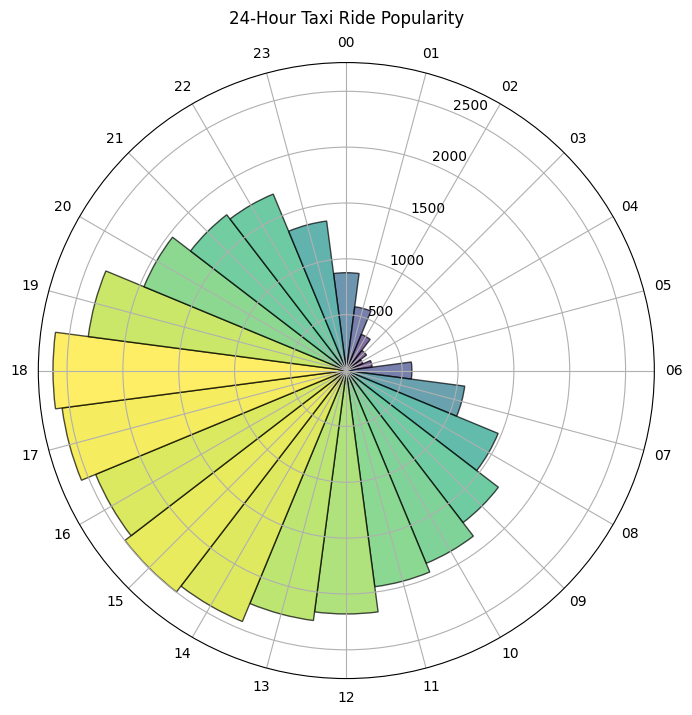

In [59]:
dataframe = get_data_for_by_hour_taxi_ride_cnt()
plot_by_hour_taxi_ride_cnt(dataframe)

### Visualization 2

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from typing import Any

def plot_by_month_hired_avg_distance(dataframe: pd.DataFrame)->Any:
    """
    Plots an animated line chart with confidence intervals for monthly taxi trip distances.

    Args:
        dataframe (pd.DataFrame): A DataFrame containing at least two columns:
                                  - 'month': The month of the trip (numeric or sortable format).
                                  - 'distance': The trip distance.

    Returns:
        Any: HTML object containing the animation, suitable for display in Jupyter Notebook.
    """
    groups = dataframe.groupby('month')['distance']
    raw = []
    for month,group in groups:
        distance = group
        mean = group.mean()
        std = np.std(distance,ddof=1)
        n = len(distance)

        margin = 1.645*std/np.sqrt(n)
        lower = mean - margin
        upper = mean + margin

        raw.append({'month':month,'mean':mean,'lower':lower,'upper':upper})
    df = pd.DataFrame(raw)

    fig,ax = plt.subplots(figsize=(10,6))
    line, = ax.plot([],[],label='Average Distance',marker = 'o',color='b')
    fill = ax.fill_between([],[],[],color='lightblue',alpha=0.2,label='95% Confidence Interval')

    ax.set_title('Monthly Taxi Trip Distance with Confidence Interval')
    ax.set_xlabel('Month')
    ax.set_ylabel('Average Distance')
    ax.legend()
    ax.grid()

    def update(frame:int)->tuple[Any,...]:
        cur = df.iloc[:frame+1]
        line.set_data(cur['month'],cur['mean'])
        fill = ax.fill_between(cur['month'],cur['lower'],cur['upper'],color='lightblue')
        return line,fill
    anim = FuncAnimation(fig,update,frames=len(df),interval=500,repeat=False)
    return HTML(anim.to_jshtml())

In [61]:
import pandas as pd
from typing import Any

def get_data_for_by_month_hired_avg_distance()->pd.DataFrame:
    """
    Retrieves and combines monthly trip distance data from Yellow Taxi and Uber trip records.
    
    Queries two tables (`yellow_taxi_trips` and `uber_trips`) to extract trip distances and 
    formats the month of the pickup time. Combines the results into a single DataFrame.

    Returns:
        pd.DataFrame: A DataFrame containing two columns:
                      - 'month': The month of the trip as a string (e.g., '01', '02').
                      - 'distance': The distance of each trip.
    """
    QUERY = """
        SELECT 
            strftime('%m', pickup_datetime) AS mon,
            trip_distance
        FROM 
            yellow_taxi_trips
        
        UNION ALL

        SELECT 
            strftime('%m', pickup_datetime) AS mon,
            trip_miles AS trip_distance
        FROM 
            uber_trips
    """
    with conn:
        results = conn.execute(QUERY).fetchall()
    
    return pd.DataFrame(results, columns=['month', 'distance']).sort_values(by='month')

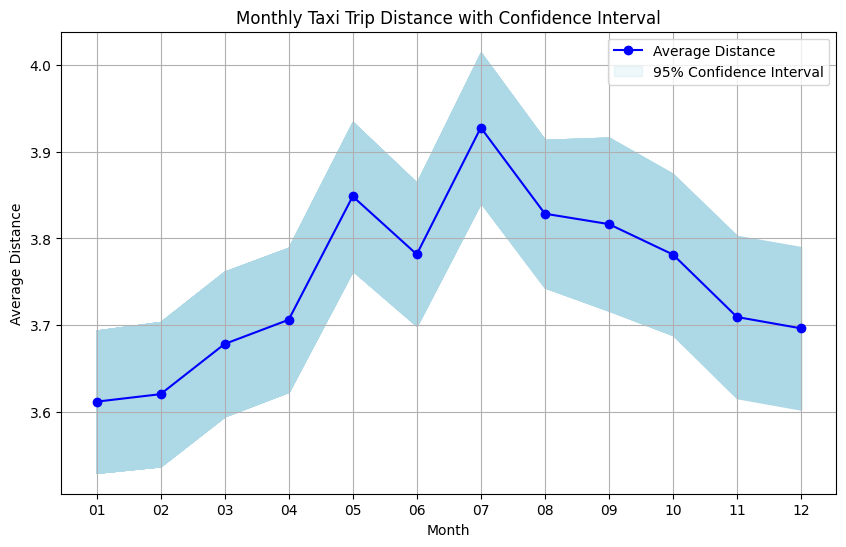

In [62]:
dataframe = get_data_for_by_month_hired_avg_distance()
plot_by_month_hired_avg_distance(dataframe)

### Visualization 3

 Which day of the week is most popular for taking a ride to an NYC-based airport?
Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport between January 2020 and August 2024, inclusive. 


In [63]:
def plot_day_of_week_frequency_to_airport(dataframe:pd.DataFrame)->None:
    """
    Plots the frequency of rides to airports for each day of the week.

    Args:
        dataframe (pd.DataFrame): A DataFrame with two columns:
            - 'day_of_week': Numeric representation of days of the week (0 for Sunday, 6 for Saturday).
            - 'ride_cnt': Count of rides on the corresponding day.

    Returns:
        None: Displays a bar chart visualization.
    """
    plt.figure(figsize=(10,6))

    x = dataframe['day_of_week'].astype(int)
    days = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
    plt.xticks(x,days)
    plt.bar(x,dataframe['ride_cnt'],label = 'Ride Count')
    plt.xlabel('Day of Week')
    plt.ylabel('Ride  count')
    plt.legend()
    plt.show()


In [64]:
def get_data_for_day_of_week_frequency_to_airport()->pd.DataFrame:
    """
    Queries the database for ride frequency data to airports grouped by the day of the week.

    Combines data from `yellow_taxi_trips` and `uber_trips` tables, filtering for rides with 
    drop-off locations near known airport boundaries (JFK, LaGuardia, and Newark). Groups the 
    results by the day of the week and counts the number of rides for each day.

    Returns:
        pd.DataFrame: A DataFrame with two columns:
            - 'day_of_week': Numeric representation of days of the week (0 for Sunday, 6 for Saturday).
            - 'ride_cnt': Count of rides on the corresponding day.
    """
    QUERY = '''
    WITH total AS(
        SELECT 
            strftime('%Y-%m-%d',pickup_datetime) AS date,
            dropoff_latitude AS lat,
            dropoff_longitude AS lng
        FROM 
            yellow_taxi_trips
        WHERE
            (dropoff_latitude BETWEEN 40.766 AND 40.790 AND dropoff_longitude BETWEEN -73.890 AND -73.860)
            OR
            (dropoff_latitude BETWEEN 40.641 AND 40.662 AND dropoff_longitude BETWEEN -73.790 AND -73.750)
            OR
            (dropoff_latitude BETWEEN 40.689 AND 40.709 AND dropoff_longitude BETWEEN -74.190 AND -74.170)
        UNION ALL

        SELECT 
            strftime('%Y-%m-%d',pickup_datetime) AS date,
            dropoff_latitude AS lat,
            dropoff_longitude AS lng
        FROM 
            uber_trips
        WHERE
            (dropoff_latitude BETWEEN 40.76 AND 40.77 AND dropoff_longitude BETWEEN -73.88 AND -73.85)
            OR
            (dropoff_latitude BETWEEN 40.62 AND 40.66 AND dropoff_longitude BETWEEN -73.82 AND -73.74)
            OR
            (dropoff_latitude BETWEEN 40.67 AND 40.70 AND dropoff_longitude BETWEEN -74.19 AND -74.15)
        )
    SELECT
        strftime('%w',date) AS day_of_week,
        COUNT(*) AS ride_cnt
    FROM total
    GROUP BY strftime('%w',date)
'''
    with conn:
        results = conn.execute(QUERY).fetchall()
    return pd.DataFrame(results,columns=['day_of_week','ride_cnt'])

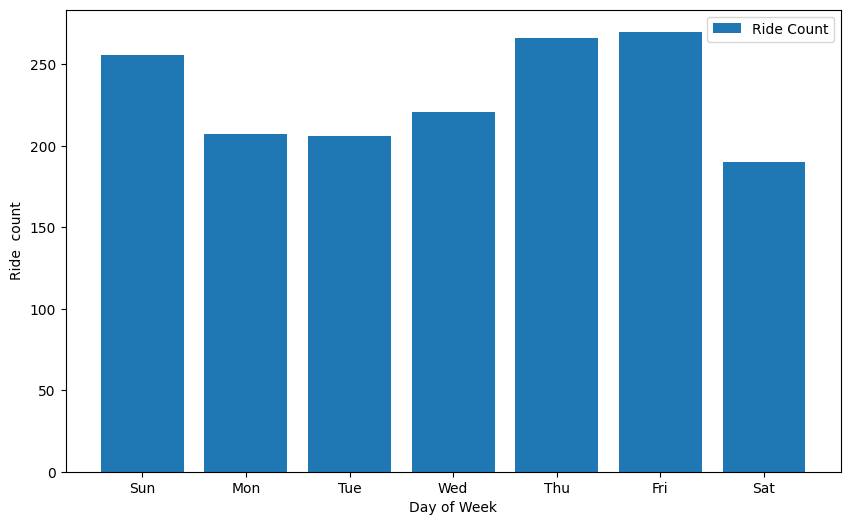

In [65]:
dataframe = get_data_for_day_of_week_frequency_to_airport()
plot_day_of_week_frequency_to_airport(dataframe)

people might start the travel at the end of the weekday(Thu,Fri),and people who travel to NY might go home at Sunday.

### Visualization 4

Visualization 4: How much do hired rides earn in total fares monthly?
Create an appropriate visualization that compares the monthly earned total fares between January 2020 through August 2024 (inclusive) for Yellow Taxis and Ubers each. Additionally, separate out fares, surcharges, taxes, and tolls.

Note: Total fare = base fare + all surcharges + taxes + tolls.


In [66]:
def plot_monthly_fare(dataframe:pd.DataFrame)->None:
    """
    Plots a comparison of monthly fare components between Uber and taxis.

    Args:
        dataframe (pd.DataFrame): A DataFrame containing the following columns:
            - 'month': Date strings formatted as '%Y-%m'.
            - 'uber_base_fare', 'uber_all_surcharges', 'uber_taxes', 'uber_tolls', 'uber_total': Uber fare components.
            - 'taxi_base_fare', 'taxi_all_surcharges', 'taxi_taxes', 'taxi_tolls', 'taxi_total': Taxi fare components.

    Returns:
        None: Displays a series of bar charts comparing fare components for Uber and taxis.
    """
    month = pd.to_datetime(dataframe['month']).apply(lambda x:x.strftime('%Y-%m'))
    uber = dataframe[['uber_base_fare','uber_all_surcharges','uber_taxes','uber_tolls','uber_total']]
    taxi = dataframe[['taxi_base_fare','taxi_all_surcharges','taxi_taxes','taxi_tolls','taxi_total']]
    components = ['total','base_fare','all_surcharges','taxes','tolls']
    x = np.arange(len(month))
    width = 0.3
    fig,ax = plt.subplots(5,1,figsize=(14,16))
    for i,component in enumerate(components):
        ax[i].bar(x-width/2,taxi[f'taxi_{component}'],width,label='taxi')
        ax[i].bar(x+width/2,uber[f'uber_{component}'],width,label='uber')

        ax[i].set_title(f'Monthly {component} comparation')
        ax[i].set_xlabel('Month')
        ax[i].set_ylabel(f'{component} Amount')

        tick_interval = 4
        xticks_indices = range(0,len(month),tick_interval)
        xtick_labels = month[xticks_indices]

        ax[i].set_xticks(xticks_indices)
        ax[i].set_xticklabels(xtick_labels)
        ax[i].legend()

    plt.tight_layout()
    plt.show()


In [67]:
def get_data_for_monthly_fare()->pd.DataFrame:
    """
    Queries the database for monthly fare data for Uber and taxis.

    Combines data from `uber_trips` and `yellow_taxi_trips` tables, calculates
    total fares and their components for each month, and aligns the results by month.

    Returns:
        pd.DataFrame: A DataFrame containing the following columns:
            - 'month': Date strings formatted as '%Y-%m'.
            - 'uber_base_fare', 'uber_all_surcharges', 'uber_taxes', 'uber_tolls', 'uber_total': Uber fare components.
            - 'taxi_base_fare', 'taxi_all_surcharges', 'taxi_taxes', 'taxi_tolls', 'taxi_total': Taxi fare components.
    """
    QUERY = '''
    WITH uber AS(
    SELECT
        SUM(COALESCE(base_passenger_fare,0)) AS uber_base_fare,
        SUM(COALESCE(congestion_surcharge,0))+SUM(COALESCE(airport_fee,0))+SUM(COALESCE(Black_Car_Fund,0)) AS uber_all_surcharges,
        SUM(COALESCE(sales_tax,0)) AS uber_taxes,
        SUM(COALESCE(tolls,0)) as uber_tolls,
        strftime('%Y-%m',pickup_datetime) AS uber_month
    FROM uber_trips
    GROUP BY strftime('%Y-%m',pickup_datetime)),
    taxi AS(
    SELECT 
        SUM(COALESCE(fare_amount,0)) AS taxi_base_fare,
        SUM(COALESCE(Miscellaneous_Extras,0))+SUM(COALESCE(improvement_surcharge,0))+SUM(COALESCE(congestion_surcharge,0))+SUM(COALESCE(airport_fee,0)) AS taxi_all_surcharges,
        SUM(COALESCE(mta_tax,0)) AS taxi_taxes,
        SUM(COALESCE(tolls_amount,0)) AS taxi_tolls,
        strftime('%Y-%m',pickup_datetime) AS taxi_month
    FROM yellow_taxi_trips
    GROUP BY strftime('%Y-%m',pickup_datetime))
    SELECT
        uber_month,uber_base_fare,uber_all_surcharges,uber_taxes,uber_tolls,
        taxi_base_fare,taxi_all_surcharges,taxi_taxes,taxi_tolls,
        uber_base_fare+uber_all_surcharges+uber_taxes+uber_tolls AS uber_total,
        taxi_base_fare+taxi_all_surcharges+taxi_taxes+taxi_tolls AS taxi_total
    FROM uber
    JOIN taxi
    ON uber_month=taxi_month
'''
    with conn:
        results = conn.execute(QUERY).fetchall()
    return pd.DataFrame(results,columns=['month','uber_base_fare','uber_all_surcharges','uber_taxes','uber_tolls',
        'taxi_base_fare','taxi_all_surcharges','taxi_taxes','taxi_tolls','uber_total','taxi_total'])

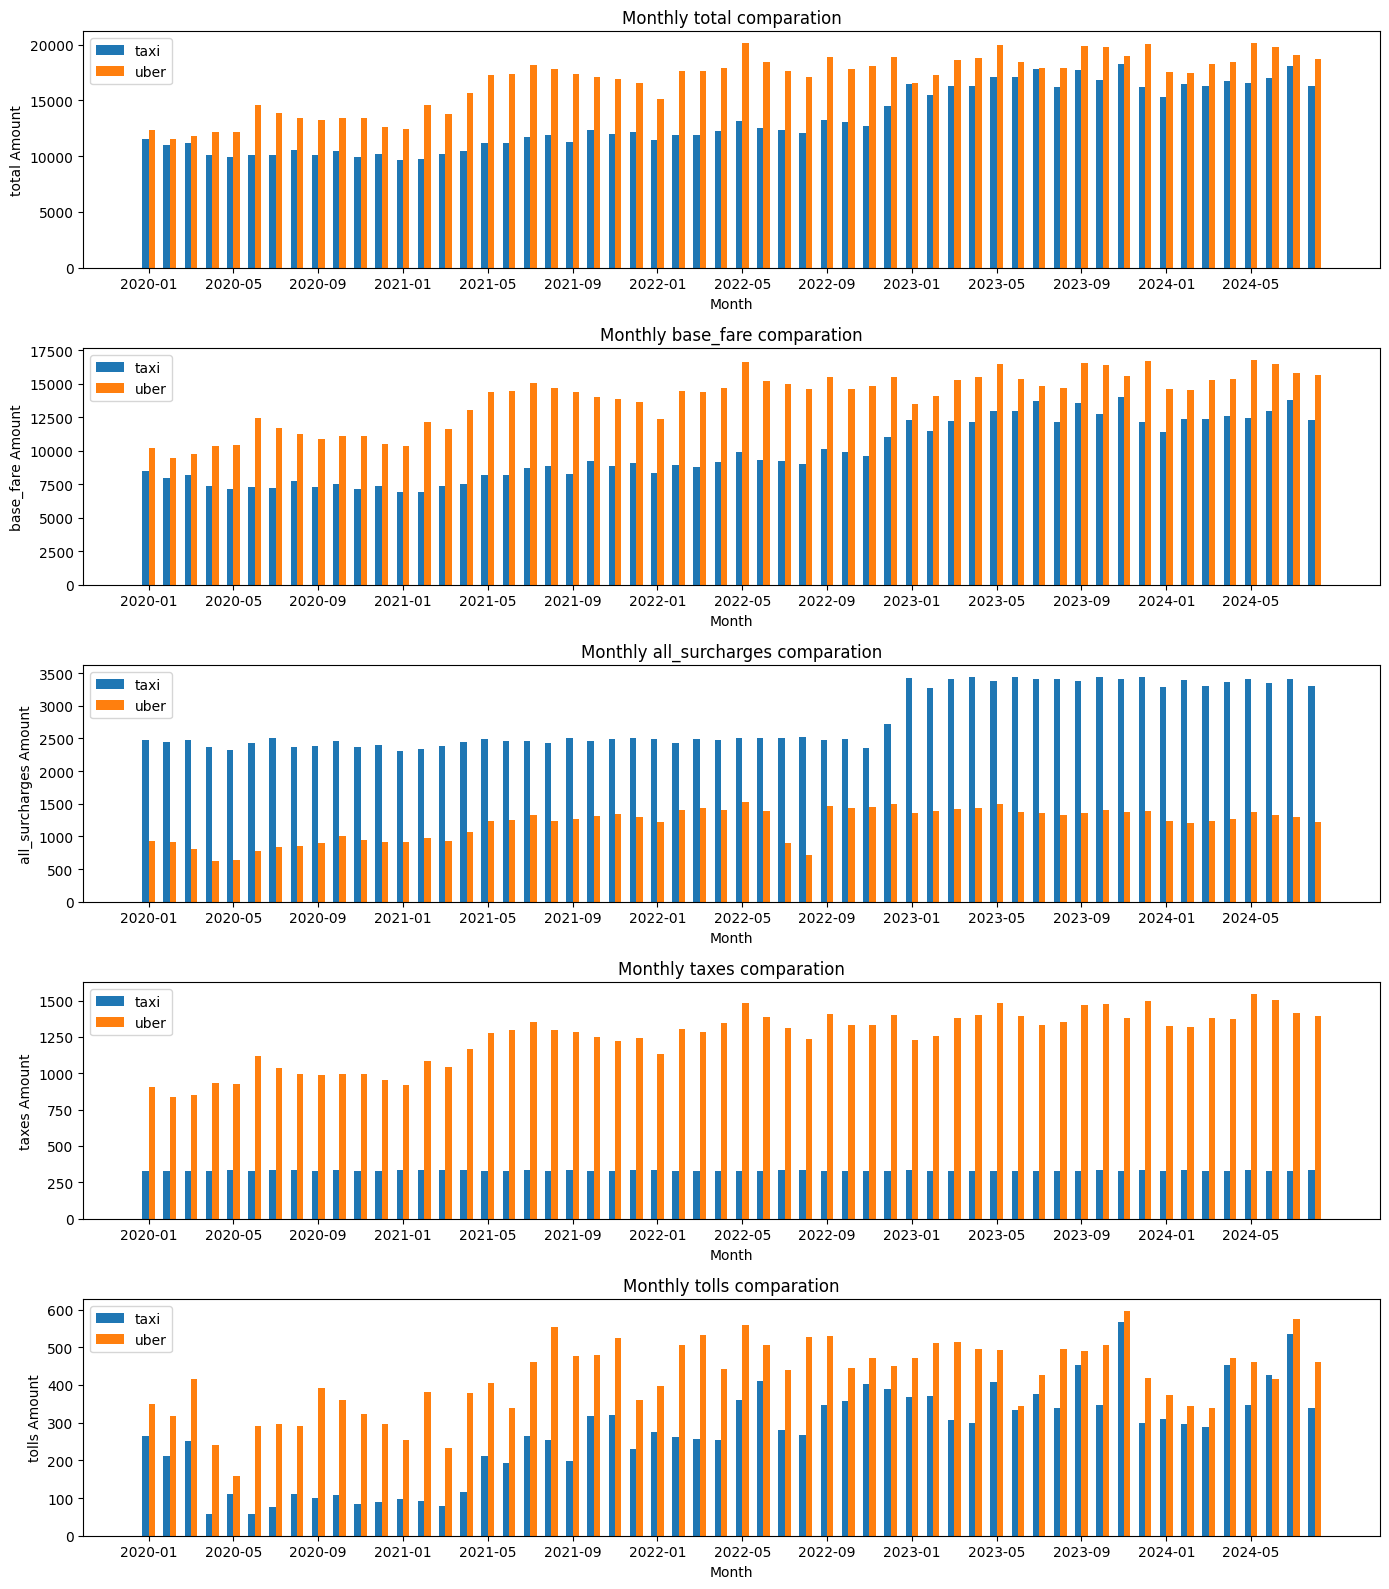

In [68]:
dataframe = get_data_for_monthly_fare()
plot_monthly_fare(dataframe)

### Visualization 5

Visualization 5: Does precipitation or distance traveled affect the amount of tip?
For the year 2022-2023, create 4 scatter plots, each one comparing amount of tip versus: 
distance for Yellow Taxi rides,
distance for Uber rides,
precipitation for Yellow Taxi rides, 
precipitation for Uber rides.

You may remove any outliers how you see fit.

If using matplotlib, then create a single figure with 2x2 subplots (example). If using another visualization library, try to accomplish something similar.


In [69]:
def remove_outliers(df:pd.DataFrame,col:str)->pd.DataFrame:
    """
    Removes outliers from a DataFrame column based on the interquartile range (IQR).

    Args:
        df (pd.DataFrame): Input DataFrame.
        col (str): Column name from which to remove outliers.

    Returns:
        pd.DataFrame: DataFrame with outliers removed.
    """
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    return df[(df[col]>=lower_bound)&(df[col]<=upper_bound)]

In [70]:
def plot_tip_factors(uber: pd.DataFrame, taxi: pd.DataFrame, weather: pd.DataFrame)->None:
    """
    Plots relationships between tips, distance, and precipitation for Uber and taxi data.

    Args:
        uber (pd.DataFrame): Uber trips data with columns ['hour', 'tips', 'distance'].
        taxi (pd.DataFrame): Taxi trips data with columns ['hour', 'tips', 'distance'].
        weather (pd.DataFrame): Weather data with columns ['hour', 'HourlyPrecipitation'].

    Returns:
        None: Displays scatter plots.
    """
  # Filter Uber and taxi data for tips less than or equal to 50.
    uber = uber[uber['tips'] <= 50]
    taxi = taxi[taxi['tips'] <= 50]

    # Merge Uber and taxi data with weather data on the 'hour' column.
    uber_weather = pd.merge(uber, weather, on='hour', how='left')
    taxi_weather = pd.merge(taxi, weather, on='hour', how='left')

    # Remove outliers based on the 'distance' column.
    uber_weather_distance = remove_outliers(uber_weather, 'distance')
    taxi_weather_distance = remove_outliers(taxi_weather, 'distance')

    # Create subplots for scatter plots.
    fig, ax = plt.subplots(2, 2, figsize=(12, 10))

    # Taxi: Distance vs. Tips.
    ax[0, 0].scatter(taxi_weather_distance['distance'], taxi_weather_distance['tips'], alpha=0.1, color='orange')
    ax[0, 0].set_title('Taxi: Distance vs. Tips')
    ax[0, 0].set_xlabel('Distance')
    ax[0, 0].set_ylabel('Tips')

    # Uber: Distance vs. Tips.
    ax[0, 1].scatter(uber_weather_distance['distance'], uber_weather_distance['tips'], alpha=0.1, color='blue')
    ax[0, 1].set_title('Uber: Distance vs. Tips')
    ax[0, 1].set_xlabel('Distance')
    ax[0, 1].set_ylabel('Tips')

   # Taxi: Precipitation vs. Tips.
    ax[1, 0].scatter(taxi_weather['HourlyPrecipitation'], taxi_weather['tips'], alpha=0.1, color='green')
    ax[1, 0].set_title('Taxi: Precipitation vs. Tips')
    ax[1, 0].set_xlabel('Precipitation')
    ax[1, 0].set_ylabel('Tips')

    # Uber: Precipitation vs. Tips.
    ax[1, 1].scatter(uber_weather['HourlyPrecipitation'], uber_weather['tips'], alpha=0.1, color='purple')
    ax[1, 1].set_title('Uber: Precipitation vs. Tips')
    ax[1, 1].set_xlabel('Precipitation')
    ax[1, 1].set_ylabel('Tips')
    
        

In [71]:
from typing import List
def get_data_for_tip_factors()->List[pd.DataFrame]:
    """
    Queries the database for tip-related factors for Uber, taxi, and weather data.

    Returns:
        List[pd.DataFrame]: A list containing:
            - Uber data (columns: ['hour', 'tips', 'distance'])
            - Taxi data (columns: ['hour', 'tips', 'distance'])
            - Weather data (columns: ['hour', 'HourlyPrecipitation'])
    """
    UBER_QUERY = '''
    SELECT
        strftime('%Y-%m-%d %H',pickup_datetime) AS hour_time,
        tips,
        trip_miles
    FROM uber_trips
    WHERE strftime('%Y',pickup_datetime) BETWEEN '2022' AND '2023'
    '''
    TAXI_QUERY = '''
    SELECT
        strftime('%Y-%m-%d %H',pickup_datetime) AS hour_time,
        tip_amount,
        trip_distance
    FROM yellow_taxi_trips
    WHERE strftime('%Y',pickup_datetime) BETWEEN '2022' AND '2023'
'''
    WEATHER_QUERY = '''
    SELECT 
        strftime('%Y-%m-%d',Date)||' '|| printf('%02d', Hour) AS hour_time,
        HourlyPrecipitation
    FROM weather_hourly
    WHERE strftime('%Y',Date) BETWEEN '2022' AND '2023'
'''
    with conn:
        uber = conn.execute(UBER_QUERY).fetchall()
        taxi = conn.execute(TAXI_QUERY).fetchall()
        weather = conn.execute(WEATHER_QUERY).fetchall()
    return  [pd.DataFrame(uber,columns=['hour','tips','distance']),pd.DataFrame(taxi,columns=['hour','tips','distance']),pd.DataFrame(weather,columns=['hour','HourlyPrecipitation'])]

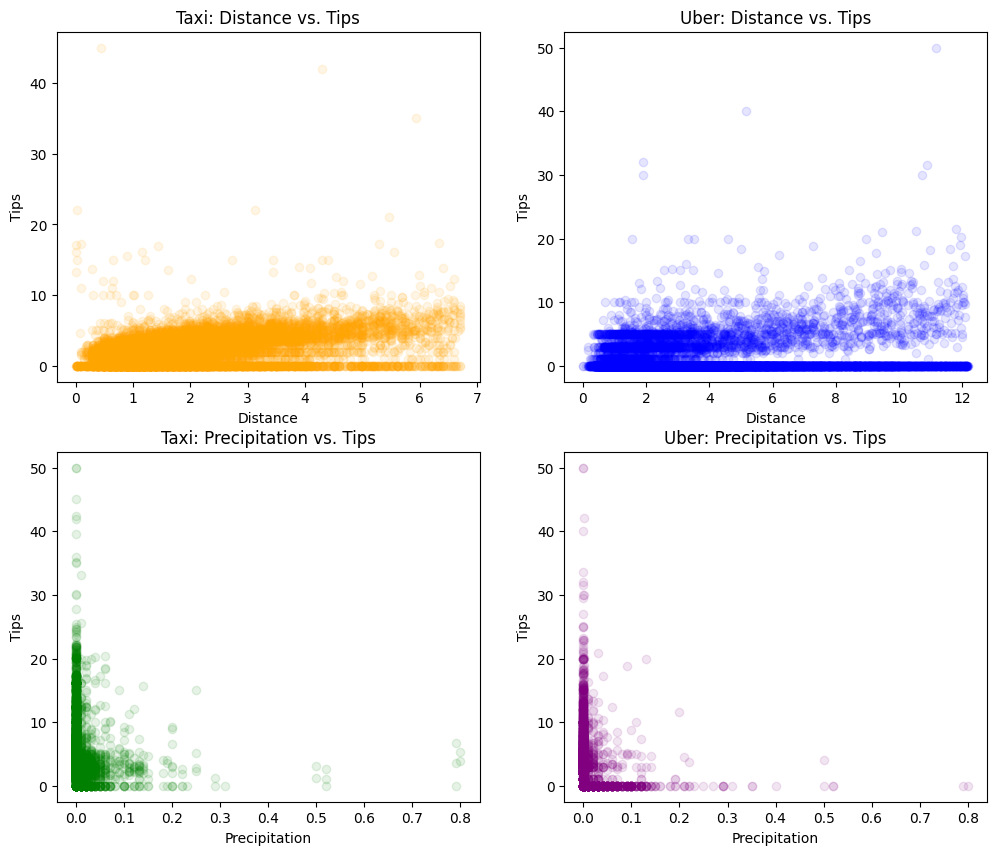

In [72]:
uber,taxi,weather = get_data_for_tip_factors()
plot_tip_factors(uber,taxi,weather)

### Visualization 6

Create a heatmap of all hired trips in 2020 over a map of the area. Consider using Folium, geopandas, KeplerGL, geoplot, or another library that helps generate geospatial visualizations.

Depending on the library you use, the visualization may not render when viewing on GitHub (after you’ve pushed your code). If that’s the case, please include a screenshot in your repository.


In [74]:
import pandas as pd
import folium
from folium.plugins import HeatMap

def plot_heatmap(dataframe: pd.DataFrame)->None:
    """
    Plots heatmaps for pickup and drop-off locations from the input DataFrame.

    Args:
        dataframe (pd.DataFrame): Input data with columns ['pick_lat', 'pick_lng', 'drop_lat', 'drop_lng'].

    Returns:
        None: Displays the heatmaps using folium.
    """
    # Group data by pickup coordinates and calculate counts
    pick_counts = dataframe.groupby(['pick_lat', 'pick_lng']).size().reset_index(name='counts')
    pick_data = pick_counts[['pick_lat', 'pick_lng', 'counts']].values

    # Group data by drop-off coordinates and calculate counts
    drop_counts = dataframe.groupby(['drop_lat', 'drop_lng']).size().reset_index(name='counts')
    drop_data = drop_counts[['drop_lat', 'drop_lng', 'counts']].values

    # Create folium map centered around average pickup location
    pick_m = folium.Map(location=[dataframe['pick_lat'].mean(), dataframe['pick_lng'].mean()], zoom_start=12)

    # Create folium map centered around average drop-off location
    drop_m = folium.Map(location=[dataframe['drop_lat'].mean(), dataframe['drop_lng'].mean()], zoom_start=12)

    # Add pickup heatmap
    HeatMap(pick_data, radius=15, blur=10, min_opacity=0.2).add_to(pick_m)

    # Add drop-off heatmap
    HeatMap(drop_data, radius=15, blur=10, min_opacity=0.2).add_to(drop_m)

    # Display the maps
    display(pick_m)
    display(drop_m)

In [75]:
def get_data_for_heatmap()->pd.DataFrame:
    """
    Fetches data for heatmap visualization, combining Uber and Taxi data for the year 2020.

    Returns:
        pd.DataFrame: A DataFrame with columns ['pick_lat', 'pick_lng', 'drop_lat', 'drop_lng'].
    """
    QUERY = '''
    SELECT
        pickup_latitude AS pick_lat,
        pickup_longitude AS pick_lng,
        dropoff_latitude AS drop_lat,
        dropoff_longitude AS drop_lng
    FROM uber_trips
    WHERE strftime('%Y', pickup_datetime) = '2020'
    UNION
    SELECT
        pickup_latitude AS pick_lat,
        pickup_longitude AS pick_lng,
        dropoff_latitude AS drop_lat,
        dropoff_longitude AS drop_lng
    FROM yellow_taxi_trips
    WHERE strftime('%Y', pickup_datetime) = '2020'
    '''

    # Execute the query and fetch results
    with conn:
        results = conn.execute(QUERY).fetchall()

    # Convert results to a DataFrame
    return pd.DataFrame(results, columns=['pick_lat', 'pick_lng', 'drop_lat', 'drop_lng'])

In [76]:
dataframe = get_data_for_heatmap()
plot_heatmap(dataframe)

### Extra Question

In 2023, whether the tips during night time(between sunset and sunrise) higher than during day time

In [77]:
QUERY_EXTRA_FILENAME = 'tips_difference_between_day_and_night'
QUERY_EXTRA = '''
WITH total AS(
SELECT
    CAST(strftime('%H',pickup_datetime) AS INTEGER) AS pick_time,
    strftime('%Y-%m-%d',pickup_datetime) AS pick_date,
    tips
FROM uber_trips
WHERE strftime('%Y',pickup_datetime)='2023'
UNION ALL
SELECT
    CAST(strftime('%H',pickup_datetime) AS INTEGER) AS pick_time,
    strftime('%Y-%m-%d',pickup_datetime) AS pick_date,
    tip_amount AS tips
FROM yellow_taxi_trips
WHERE strftime('%Y',pickup_datetime)='2023'
),
sunrise AS(
SELECT
    strftime('%Y-%m-%d',Date) AS date,
    Sunrise AS sunrise_time
FROM sunrise_daily
WHERE strftime('%Y',Date)='2023'
),
sunset AS(
SELECT
    strftime('%Y-%m-%d',Date) AS date,
    Sunset AS sunset_time
FROM sunset_daily
WHERE strftime('%Y',Date)='2023'
),
raw AS(
SELECT
    CASE
        WHEN pick_time>=sunrise_time/100 AND pick_time<=sunset_time/100 THEN 'day'
        ELSE 'night'
    END AS period,
    tips
FROM total
LEFT JOIN sunrise ON total.pick_date = sunrise.date
LEFT JOIN sunset ON total.pick_date = sunset.date
)
SELECT
    AVG(tips),
    period
FROM raw
GROUP BY period
'''
with conn:
    results = conn.execute(QUERY_EXTRA).fetchall()
results

[(2.371356109830224, 'day'), (2.1897325617766654, 'night')]

In [81]:
write_query_to_file(QUERY_1, QUERY_1_FILENAME)
write_query_to_file(QUERY_2, QUERY_2_FILENAME)
write_query_to_file(QUERY_3, QUERY_3_FILENAME)
write_query_to_file(QUERY_4, QUERY_4_FILENAME)
write_query_to_file(QUERY_5, QUERY_5_FILENAME)
write_query_to_file(QUERY_6, QUERY_6_FILENAME)
write_query_to_file(QUERY_EXTRA, QUERY_EXTRA_FILENAME)